The purpose of this project is comparison of the price of grocery products in Waitrose and Tesco.
The goal is to answer the question: Are branded goods (ie. not supermarket-own-brand) more expensive in Waitrose than tesco?

Raw data are downloaded using Selenium WebDriver and Scrapy from Waitrose and Tesco websites.

Webscraping scripts:
    Waitrose: /scripts/wt_prod_sum.py
        Note: For data scraped by wt_prod_sum.py, product data including name, price, size and link to product details are saved in one csv file
        if they are of same length; otherwise individual data are saved in separate files, and cleaned manually below.

Tesco: /scripts/tesco/

Waitrose: /scripts/waitrose

Links of grocery products data:
    Waitrose: https://www.waitrose.com/ecom/shop/browse/groceries
    Tesco: https://www.tesco.com/groceries/en-GB/


In [692]:
import pandas as pd
import numpy as np
import re
from unidecode import unidecode
import matplotlib.pyplot as plt
from tqdm import tqdm
pd.options.display.max_rows = 999
pd.options.display.max_colwidth = 500

In [2]:
def load_csv_wt(file_name, folder_link):
    """Load csv file generated by wt_prod_sum.py
    Args:
        file_name (str): name of file to be imported in notebook
        folder_link (str): folder location where csv file is saved
    Returns:
        df: Pandas dataframe object of data from the csv file in one column
    
    """
    link = folder_link + file_name
    df = pd.read_csv(link, sep='|', na_values='', header=None)
    return df

In [3]:
import_cols = ['names', 'prices', 'sizes', 'links', 'offer_flags']

In [4]:
# import csv files for category where each column of data are saved in one file
cat_col_sep = ['fresh_and_chilled']

for cat in cat_col_sep:
    for c in import_cols:
        var_name = cat+'_'+c
        globals()[var_name] = load_csv_wt(cat+'_'+c+'.csv', "../data/wt_raw/")
        globals()[var_name] = globals()[var_name].transpose()
        print(var_name, globals()[var_name].shape[0])

fresh_and_chilled_names 3645
fresh_and_chilled_prices 3786
fresh_and_chilled_sizes 3645
fresh_and_chilled_links 3645
fresh_and_chilled_offer_flags 3645


In [5]:
#The extra rows in fresh_and_chilled_prices are the strings "each est." extracted as part of prices.
fresh_and_chilled_prices[fresh_and_chilled_prices[0].str.contains('[a-zA-Z]')][0].value_counts()

each est.    141
75p           34
80p           23
70p           20
90p           17
65p           14
60p           11
50p           11
95p           10
85p            9
77p            7
61p            6
66p            6
89p            4
35p            3
55p            3
97p            2
69p            2
84p            2
45p            2
74p            2
9p             1
30p            1
17p            1
63p            1
43p            1
49p            1
34p            1
14p            1
99p            1
13p            1
44p            1
87p            1
67p            1
28p            1
37p            1
22p            1
7p             1
54p            1
16p            1
27p            1
52p            1
41p            1
32p            1
15p            1
Name: 0, dtype: int64

In [6]:
#looking at the webpage "https://www.waitrose.com/ecom/shop/browse/groceries/fresh_and_chilled", as an example, the string 'each est.' at row 4 are linked to the price in the previous row. 
print(fresh_and_chilled_prices.iloc[0:6])

           0
0      £1.00
1      £1.50
2      £1.60
3        15p
4  each est.
5      £1.15


In [7]:
est_price_each = fresh_and_chilled_prices[fresh_and_chilled_prices == 'each est.'].dropna().index

In [8]:
#include 'each est' in new column 'each_est'
fresh_and_chilled_prices['est_price_each'] = np.NaN
fresh_and_chilled_prices.loc[est_price_each - 1, 'est_price_each'] = True

!!remove est_price_each and don't add column

In [9]:
#drop rows with 'each est.' in fresh_chilled_prices
fresh_and_chilled_prices.drop(est_price_each, axis=0, inplace=True)

In [10]:
fresh_and_chilled_prices.reset_index(drop=True, inplace=True)

In [11]:
#consolidate name, price and size data of fresh and chilled category in single DataFrame
fresh_and_chilled = pd.DataFrame({'wt_name': fresh_and_chilled_names[0],
                             'wt_price': fresh_and_chilled_prices[0],
                             'wt_size': fresh_and_chilled_sizes[0],
                                  'wt_link': fresh_and_chilled_links[0],
                                  'wt_offer_flag': fresh_and_chilled_offer_flags[0],
                             'est_price_each': fresh_and_chilled_prices['est_price_each']})

In [12]:
fresh_and_chilled.head()

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
0,Essential Vegetable Selection,£1.00,750g,https://www.waitrose.com/ecom/products/essential-vegetable-selection/085141-43232-43233,False,NaN
1,Good4U Salad Topper Super Seeds,£1.50,150g,https://www.waitrose.com/ecom/products/good4u-salad-topper-super-seeds/592191-558351-558352,True,NaN
2,Tenderstem Broccoli Spears,£1.60,200g,https://www.waitrose.com/ecom/products/tenderstem-broccoli-spears/047836-23680-23681,True,NaN
3,Essential Fairtrade Bananas,15p,Typical weight 0.18kg,https://www.waitrose.com/ecom/products/essential-fairtrade-bananas/088903-45703-45704,False,True
4,Essential Semi Skimmed Milk,£1.15,2.272litre,https://www.waitrose.com/ecom/products/essential-semi-skimmed-milk/053457-26759-26760,False,NaN


In [13]:
# import csv files for categories where data are saved in file: [category]_exoffer.csv
# Note: for categories where the number of rows in all columns, data are saved in one file.
cat_onefile = ['pet', 'bakery','frozen','food_cupboard','tea_coffee_and_soft_drinks',
'beer_wine_and_spirits','toiletries_health_and_beauty','household','baby_child_and_parent',
'kitchen_dining_and_home']


for c in cat_onefile:
    filename = '../data/wt_raw/'+ c + '_exoffer.csv'
#     filename_offer = '../data/wt_raw/'+ c + '_offer.csv'

    globals()[c] = pd.read_csv(filename, sep='|', header=None)
    globals()[c].rename(columns={0:'wt_name',1:'wt_price',2:'wt_size',3:'wt_link',4:'wt_offer_flag'},inplace=True)
    globals()[c]['est_price_each'] = np.NaN
    
#     off = c + '_offer'
#     globals()[off] = pd.read_csv(filename_offer, sep='|', header=None)
#     globals()[off].rename(columns={0:'offer'},inplace=True)
    
    print(c, globals()[c].shape[0])
#     print(off, globals()[off].shape[0])

pet 434
bakery 514
frozen 644
food_cupboard 4697
tea_coffee_and_soft_drinks 1319
beer_wine_and_spirits 1630
toiletries_health_and_beauty 2344
household 971
baby_child_and_parent 527
kitchen_dining_and_home 942


Note:
In 'category_exoffer' files, column offer_flag indicate if the product is on sale

In [14]:
categories = ['pet','fresh_and_chilled','bakery','frozen','food_cupboard','tea_coffee_and_soft_drinks',
'beer_wine_and_spirits','toiletries_health_and_beauty','household','baby_child_and_parent',
'kitchen_dining_and_home']

# look for missing values in name and price columns
for category in categories:
    print(category,'\n', 'number of rows', globals()[category].shape[0], '\n', globals()[category].isnull().sum())

pet 
 number of rows 434 
 wt_name             0
wt_price            0
wt_size             2
wt_link             0
wt_offer_flag       0
est_price_each    434
dtype: int64
fresh_and_chilled 
 number of rows 3645 
 wt_name              0
wt_price             0
wt_size             63
wt_link              0
wt_offer_flag        0
est_price_each    3504
dtype: int64
bakery 
 number of rows 514 
 wt_name             0
wt_price            8
wt_size            42
wt_link             0
wt_offer_flag       0
est_price_each    514
dtype: int64
frozen 
 number of rows 644 
 wt_name             0
wt_price           12
wt_size            13
wt_link             0
wt_offer_flag       0
est_price_each    644
dtype: int64
food_cupboard 
 number of rows 4697 
 wt_name              0
wt_price             6
wt_size             28
wt_link              0
wt_offer_flag        0
est_price_each    4697
dtype: int64
tea_coffee_and_soft_drinks 
 number of rows 1319 
 wt_name              0
wt_price             5

In [15]:
bakery_nanprice_idx = bakery[bakery['wt_price'].isna() == True].index
bakery_nanprice_names = bakery.loc[bakery_nanprice_idx, 'wt_name']

In [16]:
bakery_nanprice_match_mask = bakery['wt_name'].apply(lambda x: x in list(bakery_nanprice_names))

In [17]:
# rows with missing prices are already captured in the data, so they are dropped.
bakery[bakery_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
3,Hovis Fabulous Fibre Sliced Loaf,£1.00,600g,https://www.waitrose.com/ecom/products/hovis-fabulous-fibre-sliced-loaf/859206-726202-726203,True,NaN
7,Hovis Fabulous Fibre Sliced Loaf,NaN,NaN,https://www.waitrose.com/ecom/products/hovis-fabulous-fibre-sliced-loaf/859206-726202-726203,True,NaN
35,Hovis Fabulous Fibre Sliced Loaf,£1.00,600g,https://www.waitrose.com/ecom/products/hovis-fabulous-fibre-sliced-loaf/859206-726202-726203,True,NaN
4,Hovis Glorious Grains Sliced Loaf,NaN,NaN,https://www.waitrose.com/ecom/products/hovis-glorious-grains-sliced-loaf/514364-726200-726201,True,NaN
8,Hovis Glorious Grains Sliced Loaf,NaN,NaN,https://www.waitrose.com/ecom/products/hovis-glorious-grains-sliced-loaf/514364-726200-726201,True,NaN
83,Hovis Glorious Grains Sliced Loaf,£1.00,600g,https://www.waitrose.com/ecom/products/hovis-glorious-grains-sliced-loaf/514364-726200-726201,True,NaN
5,No.1 White Sourdough Bread,NaN,NaN,https://www.waitrose.com/ecom/products/no1-white-sourdough-bread/493513-373129-373130,True,NaN
6,No.1 White Sourdough Bread,£1.60,500g,https://www.waitrose.com/ecom/products/no1-white-sourdough-bread/493513-373129-373130,True,NaN
15,Soreen 5 Lunchbox Loaves Banana,NaN,NaN,https://www.waitrose.com/ecom/products/soreen-5-lunchbox-loaves-banana/824840-451922-451923,True,NaN
112,Soreen 5 Lunchbox Loaves Banana,£1.00,150g,https://www.waitrose.com/ecom/products/soreen-5-lunchbox-loaves-banana/824840-451922-451923,True,NaN


In [18]:
bakery.drop(labels=bakery_nanprice_idx, axis=0, inplace=True)

In [19]:
bakery.drop_duplicates(inplace=True)

In [20]:
frozen_nanprice_idx = frozen[frozen['wt_price'].isna() == True].index
frozen_nanprice_names = frozen.loc[frozen_nanprice_idx, 'wt_name']

In [21]:
frozen_nanprice_match_mask = frozen['wt_name'].apply(lambda x: x in list(frozen_nanprice_names))

In [22]:
# rows with missing prices are already captured in the data, so they are dropped.
frozen[frozen_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
139,Aunt Bessie's 10 Golden Yorkshires,£1.55,220g,https://www.waitrose.com/ecom/products/aunt-bessies-10-golden-yorkshires/737574-271434-271435,False,NaN
36,Aunt Bessie's 10 Golden Yorkshires,NaN,NaN,https://www.waitrose.com/ecom/products/aunt-bessies-10-golden-yorkshires/737574-271434-271435,False,NaN
28,Aunt Bessie's 10 Golden Yorkshires,NaN,NaN,https://www.waitrose.com/ecom/products/aunt-bessies-10-golden-yorkshires/737574-271434-271435,False,NaN
9,Aunt Bessie's Crinkle Cut Chips,£1.80,900g,https://www.waitrose.com/ecom/products/aunt-bessies-crinkle-cut-chips/389578-54763-54764,False,NaN
24,Aunt Bessie's Crinkle Cut Chips,NaN,NaN,https://www.waitrose.com/ecom/products/aunt-bessies-crinkle-cut-chips/389578-54763-54764,False,NaN
32,Aunt Bessie's Crinkle Cut Chips,NaN,NaN,https://www.waitrose.com/ecom/products/aunt-bessies-crinkle-cut-chips/389578-54763-54764,False,NaN
179,Birds Eye 10 Cod Fish Fingers,£3.25,280g,https://www.waitrose.com/ecom/products/birds-eye-10-cod-fish-fingers/618561-130834-130835,False,NaN
31,Birds Eye 10 Cod Fish Fingers,NaN,NaN,https://www.waitrose.com/ecom/products/birds-eye-10-cod-fish-fingers/618561-130834-130835,False,NaN
23,Birds Eye 10 Cod Fish Fingers,£3.25,280g,https://www.waitrose.com/ecom/products/birds-eye-10-cod-fish-fingers/618561-130834-130835,False,NaN
342,Birds Eye 50 Chicken Nuggets,£4.00,790g,https://www.waitrose.com/ecom/products/birds-eye-50-chicken-nuggets/746114-261280-261281,False,NaN


In [23]:
frozen.drop(labels=frozen_nanprice_idx, axis=0, inplace=True)

In [24]:
frozen.drop_duplicates(inplace=True)

In [25]:
food_cupboard_nanprice_idx = food_cupboard[food_cupboard['wt_price'].isna() == True].index
food_cupboard_nanprice_names = food_cupboard.loc[food_cupboard_nanprice_idx, 'wt_name']

In [26]:
food_cupboard_nanprice_match_mask = food_cupboard['wt_name'].apply(lambda x: x in list(food_cupboard_nanprice_names))

In [27]:
# rows with missing prices are already captured in the data, so they are dropped.
food_cupboard[food_cupboard_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
9,Cadbury 4 Twirl,£1.00,136g,https://www.waitrose.com/ecom/products/cadbury-4-twirl/732593-104095-104096,True,NaN
16,Cadbury 4 Twirl,NaN,NaN,https://www.waitrose.com/ecom/products/cadbury-4-twirl/732593-104095-104096,True,NaN
12,Ricola Mountain Mint Sugar Free,NaN,NaN,https://www.waitrose.com/ecom/products/ricola-mountain-mint-sugar-free/895112-589683-589684,True,NaN
15,Ricola Mountain Mint Sugar Free,NaN,NaN,https://www.waitrose.com/ecom/products/ricola-mountain-mint-sugar-free/895112-589683-589684,True,NaN
1245,Ricola Mountain Mint Sugar Free,97p,45g,https://www.waitrose.com/ecom/products/ricola-mountain-mint-sugar-free/895112-589683-589684,True,NaN
11,Ricola elderflower sugar free sweets,NaN,NaN,https://www.waitrose.com/ecom/products/ricola-elderflower-sugar-free-sweets/835782-368372-368373,True,NaN
14,Ricola elderflower sugar free sweets,NaN,NaN,https://www.waitrose.com/ecom/products/ricola-elderflower-sugar-free-sweets/835782-368372-368373,True,NaN
874,Ricola elderflower sugar free sweets,97p,45g,https://www.waitrose.com/ecom/products/ricola-elderflower-sugar-free-sweets/835782-368372-368373,True,NaN
10,Ricola lemonmint sugar free sweets,NaN,NaN,https://www.waitrose.com/ecom/products/ricola-lemonmint-sugar-free-sweets/765490-368182-368183,True,NaN
13,Ricola lemonmint sugar free sweets,97p,45g,https://www.waitrose.com/ecom/products/ricola-lemonmint-sugar-free-sweets/765490-368182-368183,True,NaN


In [28]:
food_cupboard.drop(labels=food_cupboard_nanprice_idx, axis=0, inplace=True)

In [29]:
food_cupboard.drop_duplicates(inplace=True)

In [30]:
tea_coffee_and_soft_drinks_nanprice_idx = tea_coffee_and_soft_drinks[tea_coffee_and_soft_drinks['wt_price'].isna() == True].index
tea_coffee_and_soft_drinks_nanprice_names = tea_coffee_and_soft_drinks.loc[tea_coffee_and_soft_drinks_nanprice_idx, 'wt_name']

In [31]:
tea_coffee_and_soft_drinks_nanprice_match_mask = tea_coffee_and_soft_drinks['wt_name'].apply(lambda x: x in list(tea_coffee_and_soft_drinks_nanprice_names))

In [32]:
# rows with missing prices are already captured in the data, so they are dropped.
tea_coffee_and_soft_drinks[tea_coffee_and_soft_drinks_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
11,Carte Noire Classique Instant Coffee,£2.00,100g,https://www.waitrose.com/ecom/products/carte-noire-classique-instant-coffee/868515-669161-669162,True,NaN
15,Carte Noire Classique Instant Coffee,NaN,NaN,https://www.waitrose.com/ecom/products/carte-noire-classique-instant-coffee/868515-669161-669162,True,NaN
997,Carte Noire Classique Instant Coffee,£7.00,180g,https://www.waitrose.com/ecom/products/carte-noire-classique-instant-coffee/690174-669005-669006,False,NaN
10,Shloer Light Red Grape Sparkling,NaN,NaN,https://www.waitrose.com/ecom/products/shloer-light-red-grape-sparkling/803091-724071-724072,True,NaN
14,Shloer Light Red Grape Sparkling,NaN,NaN,https://www.waitrose.com/ecom/products/shloer-light-red-grape-sparkling/803091-724071-724072,True,NaN
577,Shloer Light Red Grape Sparkling,£1.46,750ml,https://www.waitrose.com/ecom/products/shloer-light-red-grape-sparkling/803091-724071-724072,True,NaN
9,Shloer Light White Grape Sparkling,NaN,NaN,https://www.waitrose.com/ecom/products/shloer-light-white-grape-sparkling/630045-723880-723881,True,NaN
13,Shloer Light White Grape Sparkling,£1.46,750ml,https://www.waitrose.com/ecom/products/shloer-light-white-grape-sparkling/630045-723880-723881,True,NaN
595,Shloer Light White Grape Sparkling,£1.46,750ml,https://www.waitrose.com/ecom/products/shloer-light-white-grape-sparkling/630045-723880-723881,True,NaN
8,Taylors of Harrogate Rich Italian Ground Coffee,£3.75,227g,https://www.waitrose.com/ecom/products/taylors-of-harrogate-rich-italian-ground-coffee/016410-7850-7851,True,NaN


In [33]:
tea_coffee_and_soft_drinks.drop(labels=tea_coffee_and_soft_drinks_nanprice_idx, axis=0, inplace=True)

In [34]:
tea_coffee_and_soft_drinks.drop_duplicates(inplace=True)

In [35]:
beer_wine_and_spirits_nanprice_idx = beer_wine_and_spirits[beer_wine_and_spirits['wt_price'].isna() == True].index
beer_wine_and_spirits_nanprice_names = beer_wine_and_spirits.loc[beer_wine_and_spirits_nanprice_idx, 'wt_name']

In [36]:
beer_wine_and_spirits_nanprice_match_mask = beer_wine_and_spirits['wt_name'].apply(lambda x: x in list(beer_wine_and_spirits_nanprice_names))

In [37]:
# all rows except 'Essential White Grapefruit' with missing prices are already captured in the data, so they are dropped.
# 'Essential White Grapefruit': this does not belong to beer_wine_and spirits category, so the rows will be removed.
beer_wine_and_spirits[beer_wine_and_spirits_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
32,Bombay Sapphire Gin,£23.00,70cl,https://www.waitrose.com/ecom/products/bombay-sapphire-gin/091026-46869-46870,False,NaN
33,Bombay Sapphire Gin,NaN,NaN,https://www.waitrose.com/ecom/products/bombay-sapphire-gin/091026-46869-46870,False,NaN
7,Charles Lecouvey Champagne Brut NV,NaN,NaN,https://www.waitrose.com/ecom/products/charles-lecouvey-champagne-brut-nv/894081-298370-298371,True,NaN
8,Charles Lecouvey Champagne Brut NV,£17.99,75cl,https://www.waitrose.com/ecom/products/charles-lecouvey-champagne-brut-nv/894081-298370-298371,True,NaN
5,Essential White Grapefruit,NaN,NaN,https://www.waitrose.com/ecom/products/essential-white-grapefruit/088428-45379-45380,False,NaN
11,Essential White Grapefruit,NaN,NaN,https://www.waitrose.com/ecom/products/essential-white-grapefruit/088428-45379-45380,False,NaN
4,Fever-Tree Indian tonic water,NaN,NaN,https://www.waitrose.com/ecom/products/fever-tree-indian-tonic-water/402597-56654-56655,False,NaN
10,Fever-Tree Indian tonic water,NaN,NaN,https://www.waitrose.com/ecom/products/fever-tree-indian-tonic-water/402597-56654-56655,False,NaN
1563,Fever-Tree Indian tonic water,£1.90,500ml,https://www.waitrose.com/ecom/products/fever-tree-indian-tonic-water/402597-56654-56655,False,NaN
1582,Fever-Tree Indian tonic water,£3.20,4x200ml,https://www.waitrose.com/ecom/products/fever-tree-indian-tonic-water/070675-35817-35818,False,NaN


In [38]:
beer_wine_and_spirits.drop(labels=beer_wine_and_spirits_nanprice_idx, axis=0, inplace=True)

In [39]:
beer_wine_and_spirits.drop_duplicates(inplace=True)

In [40]:
toiletries_health_and_beauty_nanprice_idx = toiletries_health_and_beauty[toiletries_health_and_beauty['wt_price'].isna() == True].index
toiletries_health_and_beauty_nanprice_names = toiletries_health_and_beauty.loc[toiletries_health_and_beauty_nanprice_idx, 'wt_name']

In [41]:
toiletries_health_and_beauty_nanprice_match_mask = toiletries_health_and_beauty['wt_name'].apply(lambda x: x in list(toiletries_health_and_beauty_nanprice_names))

In [42]:
# rows with missing prices are already captured in the data, so they are dropped.
toiletries_health_and_beauty[toiletries_health_and_beauty_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
11,Super Facialist Brighten Polish Wash,NaN,NaN,https://www.waitrose.com/ecom/products/super-facialist-brighten-polish-wash/545725-730686-730687,False,NaN
1753,Super Facialist Brighten Polish Wash,£10.00,125ml,https://www.waitrose.com/ecom/products/super-facialist-brighten-polish-wash/545725-730686-730687,False,NaN
12,Super Facialist Daily Moisturiser,NaN,NaN,https://www.waitrose.com/ecom/products/super-facialist-daily-moisturiser/532859-730682-730683,True,NaN
1538,Super Facialist Daily Moisturiser,£17.00,75ml,https://www.waitrose.com/ecom/products/super-facialist-daily-moisturiser/532859-730682-730683,True,NaN
14,Super Facialist Renewing Cleanser,NaN,NaN,https://www.waitrose.com/ecom/products/super-facialist-renewing-cleanser/668174-730762-730763,False,NaN
1986,Super Facialist Renewing Cleanser,£11.00,150ml,https://www.waitrose.com/ecom/products/super-facialist-renewing-cleanser/668174-730762-730763,False,NaN
15,Super Facialist Renewing Day Cream,NaN,NaN,https://www.waitrose.com/ecom/products/super-facialist-renewing-day-cream/684835-730784-730785,False,NaN
1751,Super Facialist Renewing Day Cream,£20.00,50ml,https://www.waitrose.com/ecom/products/super-facialist-renewing-day-cream/684835-730784-730785,False,NaN
17,Super Facialist Restoring Serum,NaN,NaN,https://www.waitrose.com/ecom/products/super-facialist-restoring-serum/433602-730620-730621,False,NaN
1756,Super Facialist Restoring Serum,£17.00,30ml,https://www.waitrose.com/ecom/products/super-facialist-restoring-serum/433602-730620-730621,False,NaN


In [43]:
toiletries_health_and_beauty.drop(labels=toiletries_health_and_beauty_nanprice_idx, axis=0, inplace=True)

In [44]:
toiletries_health_and_beauty.drop_duplicates(inplace=True)

In [45]:
household_nanprice_idx = household[household['wt_price'].isna() == True].index
household_nanprice_names = household.loc[household_nanprice_idx, 'wt_name']

In [46]:
household_nanprice_match_mask = household['wt_name'].apply(lambda x: x in list(household_nanprice_names))

In [47]:
# rows with missing prices are already captured in the data, so they are dropped.
household[household_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
6,Essential White Ultra Soft Bathroom Tissue,NaN,NaN,https://www.waitrose.com/ecom/products/essential-white-ultra-soft-bathroom-tissue/028863-14063-14064,False,NaN
7,Essential White Ultra Soft Bathroom Tissue,£3.75,9s,https://www.waitrose.com/ecom/products/essential-white-ultra-soft-bathroom-tissue/028863-14063-14064,False,NaN
164,Essential White Ultra Soft Bathroom Tissue,£2.00,4s,https://www.waitrose.com/ecom/products/essential-white-ultra-soft-bathroom-tissue/070464-35691-35692,False,NaN
4,Plenty The Extra Big One Kitchen Towels,NaN,NaN,https://www.waitrose.com/ecom/products/plenty-the-extra-big-one-kitchen-towels/609340-725406-725407,True,NaN
9,Plenty The Extra Big One Kitchen Towels,NaN,NaN,https://www.waitrose.com/ecom/products/plenty-the-extra-big-one-kitchen-towels/609340-725406-725407,True,NaN
25,Plenty The Extra Big One Kitchen Towels,£3.50,3 rolls,https://www.waitrose.com/ecom/products/plenty-the-extra-big-one-kitchen-towels/609340-725406-725407,True,NaN
3,Plenty The Original One,£2.50,2s,https://www.waitrose.com/ecom/products/plenty-the-original-one/669732-596437-596438,True,NaN
8,Plenty The Original One,NaN,NaN,https://www.waitrose.com/ecom/products/plenty-the-original-one/669732-596437-596438,True,NaN
12,Plenty The Original One,£2.50,2s,https://www.waitrose.com/ecom/products/plenty-the-original-one/669732-596437-596438,True,NaN
90,Plenty The Original One,£6.00,4 rolls,https://www.waitrose.com/ecom/products/plenty-the-original-one/474089-596429-596430,False,NaN


In [48]:
household.drop(labels=household_nanprice_idx, axis=0, inplace=True)

In [49]:
household.drop_duplicates(inplace=True)

In [50]:
baby_child_and_parent_nanprice_idx = baby_child_and_parent[baby_child_and_parent['wt_price'].isna() == True].index
baby_child_and_parent_nanprice_names = baby_child_and_parent.loc[baby_child_and_parent_nanprice_idx, 'wt_name']

In [51]:
baby_child_and_parent_nanprice_match_mask = baby_child_and_parent['wt_name'].apply(lambda x: x in list(baby_child_and_parent_nanprice_names))

In [52]:
# rows with missing prices are already captured in the data, so they are dropped.
baby_child_and_parent[baby_child_and_parent_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
3,Babease Beef Ragu,£1.55,130g,https://www.waitrose.com/ecom/products/babease-beef-ragu/705439-690358-690359,True,NaN
162,Babease Beef Ragu,£1.55,130g,https://www.waitrose.com/ecom/products/babease-beef-ragu/705439-690358-690359,True,NaN
14,Babease Beef Ragu,NaN,NaN,https://www.waitrose.com/ecom/products/babease-beef-ragu/705439-690358-690359,True,NaN
392,Babease Butternut Squash & Carrot,£1.25,100g,https://www.waitrose.com/ecom/products/babease-butternut-squash-carrot/468498-675620-675621,False,NaN
6,Babease Butternut Squash & Carrot,NaN,NaN,https://www.waitrose.com/ecom/products/babease-butternut-squash-carrot/468498-675620-675621,False,NaN
53,Babease Butternut Squash & Carrot,NaN,NaN,https://www.waitrose.com/ecom/products/babease-butternut-squash-carrot/468498-675620-675621,False,NaN
47,Babease Butternut Squash & Carrot,NaN,NaN,https://www.waitrose.com/ecom/products/babease-butternut-squash-carrot/468498-675620-675621,False,NaN
17,Babease Butternut Squash & Carrot,NaN,NaN,https://www.waitrose.com/ecom/products/babease-butternut-squash-carrot/468498-675620-675621,False,NaN
228,Babease Mexican Beans,£1.55,130g,https://www.waitrose.com/ecom/products/babease-mexican-beans/697157-705368-705369,True,NaN
8,Babease Mexican Beans,NaN,NaN,https://www.waitrose.com/ecom/products/babease-mexican-beans/697157-705368-705369,True,NaN


In [53]:
baby_child_and_parent.drop(labels=baby_child_and_parent_nanprice_idx, axis=0, inplace=True)

In [54]:
baby_child_and_parent.drop_duplicates(inplace=True)

In [55]:
kitchen_dining_and_home_nanprice_idx = kitchen_dining_and_home[kitchen_dining_and_home['wt_price'].isna() == True].index
kitchen_dining_and_home_nanprice_names = kitchen_dining_and_home.loc[kitchen_dining_and_home_nanprice_idx, 'wt_name']

In [56]:
kitchen_dining_and_home_nanprice_match_mask = kitchen_dining_and_home['wt_name'].apply(lambda x: x in list(kitchen_dining_and_home_nanprice_names))

In [57]:
# most rows with missing prices are already captured in the data, so they are dropped.
# the missing prices of the rest of products are filled below.
kitchen_dining_and_home[kitchen_dining_and_home_nanprice_match_mask == True].sort_values('wt_name')

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each
13,Daily Telegraph,NaN,NaN,https://www.waitrose.com/ecom/products/daily-telegraph/033027-16199-16200,True,NaN
14,Daily Telegraph,£2.50,each,https://www.waitrose.com/ecom/products/daily-telegraph/033027-16199-16200,True,NaN
37,Duracell Powerbank Rechargeable 1 Day,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-powerbank-rechargeable-1-day/677575-707547-707548,False,NaN
48,Duracell Powerbank Rechargeable 1 Day,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-powerbank-rechargeable-1-day/677575-707547-707548,False,NaN
32,Duracell Powerbank Rechargeable 2 Day,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-powerbank-rechargeable-2-day/517046-707420-707421,False,NaN
43,Duracell Powerbank Rechargeable 2 Day,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-powerbank-rechargeable-2-day/517046-707420-707421,False,NaN
36,Duracell Ultra Rechargeable AA,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-ultra-rechargeable-aa/561078-79460-79461,False,NaN
47,Duracell Ultra Rechargeable AA,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-ultra-rechargeable-aa/561078-79460-79461,False,NaN
31,Duracell Ultra Rechargeable AAA,NaN,NaN,https://www.waitrose.com/ecom/products/duracell-ultra-rechargeable-aaa/474657-66951-66952,False,NaN
42,Duracell Ultra Rechargeable AAA,£13.40,4s,https://www.waitrose.com/ecom/products/duracell-ultra-rechargeable-aaa/474657-66951-66952,False,NaN


In [58]:
# look for missing price on webpage and fill value
kitchen_dining_and_home.loc[37, 'wt_price'] = 19.99
kitchen_dining_and_home.loc[32, 'wt_price'] = 24.99
kitchen_dining_and_home.loc[36, 'wt_price'] = 13.4
kitchen_dining_and_home.loc[35, 'wt_price'] = 15
kitchen_dining_and_home.loc[34, 'wt_price'] = 12
kitchen_dining_and_home.loc[33, 'wt_price'] = 12

In [59]:
kitchen_dining_and_home.drop(labels=kitchen_dining_and_home_nanprice_idx, axis=0, inplace=True)

In [60]:
kitchen_dining_and_home.drop_duplicates(inplace=True)

In [61]:
waitrose = pd.DataFrame()
for category in categories:
    temp_df = globals()[category]
    temp_df['category'] = category
    waitrose = pd.concat([waitrose,globals()[category]], ignore_index=True, axis=0)

In [62]:
waitrose.tail()

,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each,category
17530,GQ,£2.00,each,https://www.waitrose.com/ecom/products/gq/033427-16677-16678,False,NaN,kitchen_dining_and_home
17531,TV Choice Xmas,£1.40,each,https://www.waitrose.com/ecom/products/tv-choice-xmas/033332-16579-16580,False,NaN,kitchen_dining_and_home
17532,Elle,£6.99,each,https://www.waitrose.com/ecom/products/elle/033307-16537-16538,False,NaN,kitchen_dining_and_home
17533,Whats On TV Xmas,£1.40,each,https://www.waitrose.com/ecom/products/whats-on-tv-xmas/033277-16503-16504,False,NaN,kitchen_dining_and_home
17534,TV Times Xmas,£4.25,each,https://www.waitrose.com/ecom/products/tv-times-xmas/033276-16501-16502,False,NaN,kitchen_dining_and_home


In [63]:
waitrose_clean = waitrose.copy()
waitrose_clean['wt_name'] = waitrose_clean['wt_name'].str.lower()

In [64]:
pound_mask = waitrose_clean['wt_price'].str[0] == '£'
waitrose_clean.loc[pound_mask, 'wt_price'] = waitrose_clean.loc[pound_mask, 'wt_price'].str.strip('£')
price_in_p_mask = waitrose_clean['wt_price'].str[-1]=='p'
waitrose_clean.loc[price_in_p_mask, 'wt_price'] = waitrose_clean.loc[price_in_p_mask, 'wt_price'].apply(lambda x: str(float(x.strip('p'))/100))
waitrose_clean['wt_price'] = waitrose_clean['wt_price'].astype('float')

!!make above as function to use 

In [65]:
waitrose_clean['name_split'] = waitrose_clean['wt_name'].str.split()
waitrose_clean['wt_size'] = waitrose_clean['wt_size'].str.replace(' ','').str.lower()
waitrose_clean['wt_size'].str.replace(' ','').str.lower()
waitrose_clean['total_no_word'] = waitrose_clean['name_split'].apply(lambda x: len(x))

In [66]:
def check_brand(row, keywords):
    """Check whether the product is a supermarket own brand product
    Args:
        row: row in DataFrame with product names splited and saved in a list
        keywords: keywords in product name that indicate a supermarket own brand product
    Returns:
        bool: True when product is supermarket own brand product
    """
    for w in row:
        if w in keywords:
            return True
    return False

In [67]:
# names of Waitrose brands from https://www.waitrose.com/ecom/shop/browse/groceries/waitrose_brands
wt_brands = ['waitrose','duchy','essential','no\.1','heston','cooks\'','john lewis']
waitrose_clean['own_brand'] = waitrose_clean['name_split'].apply(lambda x: check_brand(x, wt_brands))
# waitrose_brand column is assigned true if product names contain keywords of waitrose brand (wt_brands)


In [68]:
# waitrose branded products that are tagged true in waitrose_brand column will be excluded in the comparison of branded goods.
print(waitrose_clean['own_brand'].value_counts())
pd.pivot_table(waitrose_clean, values='own_brand', index='category', aggfunc=np.sum)

False    13267
True      4268
Name: own_brand, dtype: int64


,own_brand
category,
baby_child_and_parent,11.0
bakery,177.0
beer_wine_and_spirits,117.0
food_cupboard,1133.0
fresh_and_chilled,1727.0
frozen,268.0
household,269.0
kitchen_dining_and_home,223.0
pet,43.0


In [69]:
waitrose_clean.isnull().sum()
# confirm name, price and link that are mandatory field for each products do not have missing values
# est_price_each: available and set to True when price extracted on website is the price for each estimated
# size: not available for some products

wt_name               0
wt_price              0
wt_size             472
wt_link               0
wt_offer_flag         0
est_price_each    17394
category              0
name_split            0
total_no_word         0
own_brand             0
dtype: int64

In [70]:
tesco = pd.read_json('../data/tesco_w_link.json')
tesco_clean = tesco.copy()

In [71]:
tesco_clean.head()

,category,name,price,data-auto-id,id
0,Pets,Felix As Good As It Looks Food Doubly Delicious Meat 12X100g,3.49,272364671,tile-272364671
1,Pets,Whiskas 1+ Cat Food Pouches Poultry in Jelly 40x100g,8.99,284776355,tile-284776355
2,Pets,Tesco Absorbent Wood Light Weight Cat Litter 10L,4.50,252867475,tile-252867475
3,Pets,Catsan Cat Litter 10L,6.50,254960689,tile-254960689
4,Pets,Tesco Cuts In Jelly Selection Cat Food Pouches 48 X100g,8.50,291399318,tile-291399318


In [72]:
tesco_clean.rename(columns={'category':'tesco_category',
                    'name':'tesco_name',
                   'price':'tesco_price',
                   'data-auto-id':'tesco_id'}, inplace=True)
tesco_clean.drop(labels=['id'],axis=1,inplace=True)

In [73]:
tesco_details = pd.read_json('../data/tesco_details.json')

In [74]:
tesco_details.columns

Index(['url', 'name', 'price', 'prod_desc'], dtype='object')

In [75]:
tesco_details.rename(columns={'name':'tesco_details_name',
                            'price':'tesco_details_price',
                            'prod_desc':'tesco_prod_desc',
                            'url':'tesco_link'},inplace=True)

In [76]:
tesco_details['tesco_id'] = tesco_details['tesco_link'].str.extract(r'/(\d+)$')

In [77]:
tesco_details.head(2)

,tesco_link,tesco_details_name,tesco_details_price,tesco_prod_desc,tesco_id
0,https://www.tesco.com/groceries/en-GB/products/252867475,Tesco Ultra Absorbent Wood Cat Litter Light Weight 10 Litre,4.5,"[100% Natural Lightweight Low dust Ultra absorbent, Pack size: 10L, Information, Storage, Store in a cool, dry place , Preparation and Usage, 1. Provide a litter tray large enough for your cat to use comfortably. 2. Pour in Tesco Ultra Absorbent Wood Cat Litter to a depth of 2-3cm. 3. Inspect the tray daily and using a scoop remove solid waste as necessary. 4. At least weekly the tray should be emptied completely and cleaned with a mild detergent. Dry the tray thoroughly before re-filling...",252867475
1,https://www.tesco.com/groceries/en-GB/products/274777876,Tesco Chunks In Gravy Tinned Dog Food 12X400g,5.0,"[Product Description, A complete pet food for adult dogs aged 1-7years., Tesco Chunks in Gravy Selection Tinned Dog Food 12x400g 1 7 Yrs 100 % complete and balanced nutrition Essential vitamins and minerals Calcium for strong teeth and bones No artificial flavours or colours Zinc for healthy skin and coat We've been creating deliciously tempting meals with our team of pet nutrition experts for over 30 years. Carefully prepared using wholesome nutritious ingredients from our truste...",274777876


In [78]:
tesco_details['tesco_id'] = tesco_details['tesco_id'].astype('int')

In [220]:
tesco_details_uniq = tesco_details.drop_duplicates(subset='tesco_id')

In [79]:
tesco_clean['tesco_category'].unique()

array(['Pets', 'Bakery', 'Baby', 'Drinks', 'Fresh Food', 'Food Cupboard',
       'Household', 'Health & Beauty', 'Home & Ents', 'Frozen Food'],
      dtype=object)

In [80]:
waitrose_clean['category'].unique()

array(['pet', 'fresh_and_chilled', 'bakery', 'frozen', 'food_cupboard',
       'tea_coffee_and_soft_drinks', 'beer_wine_and_spirits',
       'toiletries_health_and_beauty', 'household',
       'baby_child_and_parent', 'kitchen_dining_and_home'], dtype=object)

In [81]:
# rename category in tesco_clean and waitrose_clean to be in the same category names
mapping_dict_tesco = {'Pets':'pet',
               'Bakery':'bakery',
                      'Fresh Food':'fresh_and_chilled',
               'Frozen Food':'frozen',
               'Food Cupboard':'food_cupboard',
               'Drinks':'drinks',
               'Health & Beauty':'toiletries_health_and_beauty',
                     'Household':'household',
                     'Baby':'baby_child_and_parent',
                     'Home & Ents':'home'}

mapping_dict_waitrose = {'pet':'pet',
               'bakery':'bakery',
                         'fresh_and_chilled':'fresh_and_chilled',
               'frozen':'frozen',
               'food_cupboard':'food_cupboard',
                      'toiletries_health_and_beauty':'toiletries_health_and_beauty',
                     'household':'household',
                     'baby_child_and_parent':'baby_child_and_parent',
                'tea_coffee_and_soft_drinks':'drinks',
                'beer_wine_and_spirits':'drinks',
               'kitchen_dining_and_home':'home'}


tesco_clean['tesco_category'] = tesco_clean['tesco_category'].map(mapping_dict_tesco,na_action='ignore')
waitrose_clean.loc[waitrose_clean['category']!='tea_coffee_and_soft_drinks', 'tea_coffee_and_soft_drinks_flag'] = False
waitrose_clean.loc[waitrose_clean['category']=='tea_coffee_and_soft_drinks', 'tea_coffee_and_soft_drinks_flag'] = True
waitrose_clean.loc[waitrose_clean['category']!='beer_wine_and_spirits', 'beer_wine_and_spirits_flag'] = False
waitrose_clean.loc[waitrose_clean['category']=='beer_wine_and_spirits', 'beer_wine_and_spirits_flag'] = True

waitrose_clean['category'] = waitrose_clean['category'].map(mapping_dict_waitrose,na_action='ignore')

In [82]:
waitrose_clean['tea_coffee_and_soft_drinks_flag'].value_counts()

False    16222
True      1313
Name: tea_coffee_and_soft_drinks_flag, dtype: int64

In [83]:
waitrose_clean['beer_wine_and_spirits_flag'].value_counts()

False    15915
True      1620
Name: beer_wine_and_spirits_flag, dtype: int64

In [84]:
tesco_clean['tesco_name'] = tesco_clean['tesco_name'].str.lower()
tesco_clean['tesco_name_split'] = tesco_clean['tesco_name'].str.split()
tesco_clean['tesco_size'] = np.NaN

#extract sizes that have patterns for sizes

patterns = [r'(\d+m?m? *[Xx] *\d+[a-zA-Z]*) ?',
            r'(\d+m?m? *[Xx] *\d+[a-zA-Z]*)$',
            r'(\d+g$)',
            r'(\d+.?\d* *mm)',
            r'(\d+.?\d* *cm)',
            r'(\d+.?\d* *me?t?r?e?s?l?)',
            r'(\d+.?\d* *cl)',
            r'(\d+.?\d* *inc?h?)',
            r'(\d+.?\d* *oz)',
            r'(\d+.?\d* *pcs?)',
            r' (\d+) ',
           r' (\d+.?\d* *litres*)',
           r'(\d+.?\d* *kg)',
           r'(\d+.?\d* *g)',
           r'(\d+ *")',
           r'(\d+.?\d* *l)',
           r'(\d+.?\d* *ltrs?)',
           r'(\d+\'?s)',
           r'(\d+pk)',
           r'(x ?\d+ ?)',
           r'(\d+ ?packs?)']

for pattern in patterns:
    val = tesco_clean[tesco_clean['tesco_size'].isna()].loc[:,'tesco_name'].str.extract(pattern).dropna()
    index = val[val[0].notnull()].index
    tesco_clean.loc[index,'tesco_size'] = val[0]

#extract sizes of products that are sold as each one
each_mask = tesco_clean['tesco_name_split'].str[-1] == 'each'
tesco_clean.loc[each_mask, 'tesco_size'] = 'each'
tesco_clean['tesco_size'] = tesco_clean['tesco_size'].str.replace(' ','').str.lower()


#export quantity to quickly confirm if extracted values look reasonable
tesco_clean['tesco_size'].value_counts().to_csv('../data/processed/tesco_size.csv')

to check tesco_size.csv

In [85]:
tesco_clean.isnull().sum()

tesco_category         0
tesco_name             0
tesco_price          215
tesco_id               0
tesco_name_split       0
tesco_size          3711
dtype: int64

In [86]:
# prices of these products are missing because they are unavailable at the time of web scraping.
# these rows will be dropped.
tesco_clean[tesco_clean['tesco_price'].isna()]

,tesco_category,tesco_name,tesco_price,tesco_id,tesco_name_split,tesco_size
70,baby_child_and_parent,fred & flo 60 sensitive toilet wipes,NaN,301883882,"[fred, &, flo, 60, sensitive, toilet, wipes]",60
146,household,andrex toilet tissue gentle clean 24 roll,NaN,302321901,"[andrex, toilet, tissue, gentle, clean, 24, roll]",24
161,household,andrex classic clean washlets 40 refill wipes,NaN,297418052,"[andrex, classic, clean, washlets, 40, refill, wipes]",40
223,frozen,tesco frozen blueberries 400g,NaN,294892069,"[tesco, frozen, blueberries, 400g]",400g
231,frozen,tesco 4 southern fried chicken steaks 380g,NaN,297683145,"[tesco, 4, southern, fried, chicken, steaks, 380g]",380g
296,baby_child_and_parent,johnson's baby cotton buds 200 pieces,NaN,303350127,"[johnson's, baby, cotton, buds, 200, pieces]",200
297,baby_child_and_parent,fred & flo 150 nappy bags,NaN,302083047,"[fred, &, flo, 150, nappy, bags]",150
299,baby_child_and_parent,tesco nappy bags 300,NaN,260274296,"[tesco, nappy, bags, 300]",NaN
364,food_cupboard,growers harvest tomato passata 500g,NaN,300522845,"[growers, harvest, tomato, passata, 500g]",500g
421,frozen,grower's harvest sweetcorn 907g,NaN,299539429,"[grower's, harvest, sweetcorn, 907g]",907g


In [87]:
tesco_miss_price_idx = tesco_clean[tesco_clean['tesco_price'].isna()].index

In [88]:
tesco_clean.drop(labels=tesco_miss_price_idx,axis=0,inplace=True)

In [89]:
# export rows that do not have data in 'size' column but have numbers in 'name' column (ie. likely to have quantity/size info),
# to confirm their names do not contain have size information eg. model number in the product name
tesco_missing_quantity = tesco_clean[tesco_clean['tesco_size'].isna() & tesco_clean['tesco_name'].str.contains(r'\d+')].loc[:,'tesco_name']
tesco_missing_quantity.to_csv('../data/processed/tesco_missing_quantity.csv')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  after removing the cwd from sys.path.


to check tesco_missing_quantity.csv

In [90]:
# information from https://www.tesco.com/groceries/en-GB/zone/exclusively-at-tesco
tesco_brands = ['tesco','hearty food co','h\.? ?w\.? ?nevill\'s','grower\'?s? harvest','stockwell ?& ?co','ms molly\'?s','butcher\'?s choice','creamfields','eastman\'?s']
tesco_clean['tesco_brand'] = tesco_clean['tesco_name_split'].apply(lambda x: check_brand(x, tesco_brands))

In [91]:
tesco_clean['tesco_brand'].value_counts()

False    18777
True      6639
Name: tesco_brand, dtype: int64

In [92]:
def matchfunc(row):
    """Match Waitrose products in waitrose_clean to tesco_clean using product name, 
        and return the index/indices of Tesco products that have the closest product name within tesco_clean
    Args:
        row (row in DataFrame): each row in waitrose_clean DataFrame
    Returns:
        tesco_index: index number(s) of closest matched product(s) in tesco_clean DataFrame
        word_match_count: number of words in product names at returned tesco_index that match with the product name (wt_name)
        match_flag: set to True when all words in product name are found in the product with returned tesco_index, and 
        wt_quantity match to the 'quantity' column of product with returned tesco_index
    
    """
    
    wt_name = row['wt_name']
    wt_name_split_eng_char = unidecode(row['wt_name']).split()
    wt_name_split = row['name_split']
    words_to_match = wt_name_split + [w for w in wt_name_split_eng_char if w not in wt_name_split]
    wt_quantity = row['wt_size']
    wt_category = row['category']
    word_match_count = 0
    match_flag = False

    match_df = tesco_clean[(tesco_clean['tesco_name'].str.contains(re.escape(wt_name)))&(tesco_clean['tesco_brand']==False)&(tesco_clean['tesco_category']==wt_category)]

    if wt_quantity:
        match_qty_result = match_df[match_df['tesco_size'] == wt_quantity]
        if len(match_qty_result) == 1:
            match_df = match_qty_result
            word_match_count = len(wt_name_split)
            wt_name_qty = wt_name_split
            wt_name_qty.append(wt_quantity)
            
            if list(match_df.loc[:,'tesco_name_split'])[0] == wt_name_qty:
                match_flag = True
                
            elif wt_quantity == 'each' and (str(match_qty_result['tesco_size']) == 'nan' or str(match_qty_result['tesco_size']) == ''):
                match_flag = True

    if len(match_df) != 1:
        match_df = tesco_clean[(tesco_clean['tesco_brand']==False)&(tesco_clean['tesco_category']==wt_category)].copy()
        for w in words_to_match:
            match_result = match_df['tesco_name_split'].apply(lambda x: w in x)
            
            if match_result.sum() < len(match_df) and match_result.sum() >= 1:
                word_match_count += 1
                match_df = match_df[match_result]
        
        match_qty_result = match_df[match_df['tesco_size'] == wt_quantity]
        
        if len(match_qty_result) == 1:
            match_df = match_qty_result
            
    tesco_index = match_df.index
        
    return tesco_index, word_match_count, match_flag

In [93]:
# look for best match of products in tesco_clean
tqdm.pandas(desc="Progress bar")
match_result = waitrose_clean[waitrose_clean['own_brand']==False].progress_apply(lambda x: matchfunc(x), axis=1)

/opt/anaconda3/lib/python3.7/site-packages/tqdm/std.py:648: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
Progress bar: 100%|██████████| 13267/13267 [05:15<00:00, 42.03it/s]


In [94]:
waitrose_clean['tesco_match_index'] = match_result.apply(lambda x: x[0])
waitrose_clean['tesco_match_count'] = match_result.apply(lambda x: x[1])
waitrose_clean['tesco_match_flag'] = match_result.apply(lambda x: x[2])

In [95]:
waitrose_clean['no_diff_word'] = waitrose_clean['total_no_word'] - waitrose_clean['tesco_match_count']

In [96]:
waitrose_clean_cols = waitrose_clean.columns
tesco_clean_cols = tesco_clean.columns
wt_tesco_details_cols = pd.concat([pd.Series(['waitrose_index']), pd.Series(['tesco_index']), pd.Series(waitrose_clean_cols), pd.Series(tesco_clean_cols)],ignore_index=True)

In [97]:
# The smaller the number of words (no_diff_word) that Waitrose product name is different from Tesco product,
# the more likely both product is the same. 
waitrose_clean['no_diff_word'].value_counts().sort_index(ascending=True)

0.0     1255
1.0     1720
2.0     2905
3.0     3104
4.0     2256
5.0     1106
6.0      515
7.0      251
8.0       94
9.0       49
10.0       8
11.0       4
Name: no_diff_word, dtype: int64

In [98]:
# empty DataFrame for storing merged DataFrame of waitrose_clean and matched product details from tesco_clean
wt_tesco_match_details = pd.DataFrame()

In [99]:
waitrose_clean.columns

Index(['wt_name', 'wt_price', 'wt_size', 'wt_link', 'wt_offer_flag',
       'est_price_each', 'category', 'name_split', 'total_no_word',
       'own_brand', 'tea_coffee_and_soft_drinks_flag',
       'beer_wine_and_spirits_flag', 'tesco_match_index', 'tesco_match_count',
       'tesco_match_flag', 'no_diff_word'],
      dtype='object')

In [100]:
def merge_wt_tesco_match(no_diff_word):
    
    '''
    merge waitrose_clean with Tesco product details in tesco_clean with no_diff_word in waitrose_clean['no_diff_word']
    '''
    
    wt_filtered = waitrose_clean.loc[waitrose_clean['no_diff_word']==no_diff_word].copy()

    first_row = True

    for i,v in tqdm(wt_filtered.iterrows()):

        tesco_match_index = v['tesco_match_index']

        if type(tesco_match_index) == pd.Int64Index:
            for n in tesco_match_index:
#                 add waitrose_clean index in the first column of row
                row = pd.Series({'waitrose_index':i})
#                 add relevant row from wt_filtered
                row = row.append(v)
#                 add index from tesco_clean in the row
                row = row.append(pd.Series({'tesco_index':n}))
#                 add relevant row from tesco_clean
                row = row.append(tesco_clean.loc[n])
#                 add the merged row to merged df
                if first_row == True:
                    merged_df = pd.DataFrame(row)
                    merged_df = merged_df.transpose()
                    first_row = False
                else:
                    merged_df = merged_df.append(row, ignore_index=True)

    return merged_df

For Waitrose products for which there are similar matches in Tesco dataset (ie. waitrose_clean['tesco_match_flag'] == False),

product descriptions on Waitrose website will be web-scraped to see if they are matches. 

We will look into products of which no_diff_word is from 0 to 3

In [101]:
for i in range(4):
    df_name = 'wt_tesco_match_details_'+str(i)
    globals()[df_name] = merge_wt_tesco_match(i)
    wt_tesco_match_details = pd.concat([wt_tesco_match_details, globals()[df_name]],axis=0)
    print(f'no_diff_word {i} completed')

1255it [00:28, 43.59it/s]
12it [00:00, 50.65it/s]

no_diff_word 0 completed


1720it [1:32:18,  3.22s/it] 
0it [00:00, ?it/s]

no_diff_word 1 completed


2905it [13:43:08, 17.00s/it]  
6it [00:00, 54.99it/s]

no_diff_word 2 completed


3104it [16:39:03, 19.31s/it] 


no_diff_word 3 completed


In [106]:
wt_tesco_match_details.to_csv('../data/processed/wt_tesco_match_details_diff_0_3_20210211.csv',sep='|')

In [107]:
print(wt_tesco_match_details.columns)
print(wt_tesco_match_details.shape[0])

Index(['waitrose_index', 'wt_name', 'wt_price', 'wt_size', 'wt_link',
       'wt_offer_flag', 'est_price_each', 'category', 'name_split',
       'total_no_word', 'own_brand', 'tea_coffee_and_soft_drinks_flag',
       'beer_wine_and_spirits_flag', 'tesco_match_index', 'tesco_match_count',
       'tesco_match_flag', 'no_diff_word', 'tesco_index', 'tesco_category',
       'tesco_name', 'tesco_price', 'tesco_id', 'tesco_name_split',
       'tesco_size', 'tesco_brand'],
      dtype='object')
437881


In [108]:
wt_tesco_match_details

,waitrose_index,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each,category,name_split,total_no_word,...,tesco_match_flag,no_diff_word,tesco_index,tesco_category,tesco_name,tesco_price,tesco_id,tesco_name_split,tesco_size,tesco_brand
0,2,bonio,1.8,650g,https://www.waitrose.com/ecom/products/bonio/028428-13834-13835,False,NaN,pet,[bonio],1,...,False,0,926,pet,bonio the original biscuit dog food 650g,1.5,254906225,"[bonio, the, original, biscuit, dog, food, 650g]",650g,False
1,2,bonio,1.8,650g,https://www.waitrose.com/ecom/products/bonio/028428-13834-13835,False,NaN,pet,[bonio],1,...,False,0,1148,pet,bonio the original biscuit dog food 1.2kg,2.75,257237977,"[bonio, the, original, biscuit, dog, food, 1.2kg]",1.2kg,False
2,2,bonio,1.8,650g,https://www.waitrose.com/ecom/products/bonio/028428-13834-13835,False,NaN,pet,[bonio],1,...,False,0,5829,pet,bonio chicken 650g,1.5,267073586,"[bonio, chicken, 650g]",650g,False
3,6,winalot shapes,1.95,800g,https://www.waitrose.com/ecom/products/winalot-shapes/028436-13842-13843,True,NaN,pet,"[winalot, shapes, 800g]",2,...,True,0,498,pet,winalot shapes 800g,1.5,254906283,"[winalot, shapes, 800g]",800g,False
4,12,gourmet perle ocean delicacies,5.5,12x85g,https://www.waitrose.com/ecom/products/gourmet-perle-ocean-delicacies/086671-44300-44300,True,NaN,pet,"[gourmet, perle, ocean, delicacies, 12x85g]",4,...,False,0,279,pet,gourmet perle ocean delicacies in gravy 12x85g,3.99,260589803,"[gourmet, perle, ocean, delicacies, in, gravy, 12x85g]",12x85g,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196597,17495,world cup adren stickers,1.5,NaN,https://www.waitrose.com/ecom/products/world-cup-adren-stickers/682826-654643-654644,False,NaN,home,"[world, cup, adren, stickers]",4,...,False,3,20677,home,sparkle world,4.99,308263620,"[sparkle, world]",NaN,False
196598,17495,world cup adren stickers,1.5,NaN,https://www.waitrose.com/ecom/products/world-cup-adren-stickers/682826-654643-654644,False,NaN,home,"[world, cup, adren, stickers]",4,...,False,3,22786,home,guinness world records 2021,10,306891023,"[guinness, world, records, 2021]",NaN,False
196599,17504,korbond double clothes brush,6,NaN,https://www.waitrose.com/ecom/products/korbond-double-clothes-brush/621380-588567-588568,False,NaN,home,"[korbond, double, clothes, brush]",4,...,False,3,6113,home,korbond general purpose scissors 5inches,3,258196435,"[korbond, general, purpose, scissors, 5inches]",5inch,False
196600,17519,punch coronations tubes cigar,14.4,each,https://www.waitrose.com/ecom/products/punch-coronations-tubes-cigar/664221-547054-547055,False,NaN,home,"[punch, coronations, tubes, cigar]",4,...,False,3,16630,home,jelly belly air freshener island punch,2.7,278538664,"[jelly, belly, air, freshener, island, punch]",NaN,False


In [ ]:
# wt_tesco_match_details = pd.read_csv('../data/processed/wt_tesco_match_details_diff_0_3.csv', sep='|')

Note:
     web scraping of product descriptions was done multiple times. file name convention example:
     1st time. 
         -exported files with links for scraping: ../data/processed/products_to_match.csv
         -product descriptions result file: ../data/processed/prod_page_details.csv
     2nd time.
         -exported files with links for scraping: ../data/processed/products_to_match_2.csv
         -product descriptions result file: ../data/processed/prod_page_details_2.csv

In [109]:
products_to_match = wt_tesco_match_details.loc[(wt_tesco_match_details['no_diff_word']>=0)&(wt_tesco_match_details['no_diff_word']<=3)]

In [110]:
products_to_match_1 = pd.read_csv('../data/processed/products_to_match.csv',sep='|')

products_to_match_2 = pd.read_csv('../data/processed/products_to_match_2.csv',sep='|')

products_to_match_3 = pd.read_csv('../data/processed/products_to_match_3.csv',sep='|')

products_to_match_4 = pd.read_csv('../data/processed/products_to_match_4.csv',sep='|')

products_to_match_5 = pd.read_csv('../data/processed/products_to_match_5.csv',sep='|')

products_to_match_6 = pd.read_csv('../data/processed/products_to_match_6.csv',sep='|')

products_to_match_7 = pd.read_csv('../data/processed/products_to_match_7.csv',sep='|')

products_to_match_8 = pd.read_csv('../data/processed/products_to_match_8.csv',sep='|')

In [126]:
links_to_match = pd.concat([products_to_match_1['link'], products_to_match_2['link'], products_to_match_3['link'],\
                 products_to_match_4['link'], products_to_match_5['link'], products_to_match_6['link'],\
                 products_to_match_7['link'], products_to_match_8['link']])

In [128]:
links_to_match = links_to_match.drop_duplicates()

In [141]:
links_to_match = set(links_to_match)

In [143]:
# latest list of products for investigating/web scraping
products_to_look_into = products_to_match['wt_link'].progress_apply(lambda x: x not in links_to_match)


Progress bar: 100%|██████████| 437881/437881 [00:00<00:00, 1000470.67it/s][A


In [147]:
products_to_look_into.value_counts()

False    437881
Name: wt_link, dtype: int64

In [ ]:
# products_to_look_into.to_csv('../data/processed/products_to_match_x.csv',sep='|')

In [149]:
prod_details = pd.read_csv('../data/wt_raw/prod_page_details.csv', sep='|')
prod_details_2 = pd.read_csv('../data/wt_raw/prod_page_details_2.csv', sep='|')
prod_details_3 = pd.read_csv('../data/wt_raw/prod_page_details_3.csv', sep='|')
prod_details_4 = pd.read_csv('../data/wt_raw/prod_page_details_4.csv', sep='|')
prod_details_5 = pd.read_csv('../data/wt_raw/prod_page_details_5.csv', sep='|')
prod_details_6 = pd.read_csv('../data/wt_raw/prod_page_details_6.csv', sep='|')
prod_details_7 = pd.read_csv('../data/wt_raw/prod_page_details_7.csv', sep='|')
prod_details_8 = pd.read_csv('../data/wt_raw/prod_page_details_8.csv', sep='|')

In [150]:
prod_details = pd.concat([prod_details, prod_details_2, prod_details_3, prod_details_4, prod_details_5, prod_details_6, prod_details_7, prod_details_8],axis=0)
prod_details.drop_duplicates(keep='first', inplace=True)

In [154]:
prod_details.rename(columns={'link':'wt_link'}, inplace=True)

In [155]:
prod_details.fillna('',inplace=True)
prod_details['comb_desc'] = prod_details['prod_desc']+' '+prod_details['mktg_desc']
prod_details['comb_desc'] = prod_details['comb_desc'].str.lower()

In [156]:
wt_tesco_match_details = wt_tesco_match_details.merge(prod_details,how='left',on='wt_link')

In [223]:
wt_tesco_match_details = wt_tesco_match_details.merge(tesco_details_uniq,on='tesco_id',how='left')

In [224]:
wt_tesco_match_details.head()

,waitrose_index,wt_name,wt_price,wt_size,wt_link,wt_offer_flag,est_price_each,category,name_split,total_no_word,...,tesco_size,tesco_brand,prod_desc,mktg_desc,offer,comb_desc,tesco_link,tesco_details_name,tesco_details_price,tesco_prod_desc
0,2,bonio,1.8,650g,https://www.waitrose.com/ecom/products/bonio/028428-13834-13835,False,NaN,pet,[bonio],1,...,650g,False,"Oven-baked to give a delicious, crunchy texture that helps keep your dog's teeth healthy. Wholesome and nutritious - a great treat for morning, noon and night! Low in fat to help your dog maintain a healthy body condition. Developed using carefully selected ingredients. A complementary pet food, this tasty snack that's sure to get your dog's mouth watering and his tail wagging! Complementary pet food for adult dogs. Watch your dog's tail wag at the sight of our delicious BONIO® Adult dog bis...",,,"oven-baked to give a delicious, crunchy texture that helps keep your dog's teeth healthy. wholesome and nutritious - a great treat for morning, noon and night! low in fat to help your dog maintain a healthy body condition. developed using carefully selected ingredients. a complementary pet food, this tasty snack that's sure to get your dog's mouth watering and his tail wagging! complementary pet food for adult dogs. watch your dog's tail wag at the sight of our delicious bonio® adult dog bis...",https://www.tesco.com/groceries/en-GB/products/254906225,Bonio The Original Biscuit Dog Food 650G,1.50,"[Complementary pet food for adult dogs., Watch your dog's tail wag at the sight of our delicious BONIO® Adult dog biscuits, a treat that he will enjoy at morning, noon and night!, Our tasty treats are enriched with vitamins and minerals l nutrients to help keep your dog supported and healthy, whilst providing him with a yummy treat for him to enjoy! Our PURINA® vets and nutritionists have developed our BONIO® Adult dog biscuits with your dog in mind, helping to care for his teeth, gums and e..."
1,2,bonio,1.8,650g,https://www.waitrose.com/ecom/products/bonio/028428-13834-13835,False,NaN,pet,[bonio],1,...,650g,False,"Oven-baked to give a delicious, crunchy texture that helps keep your dog's teeth healthy. Wholesome and nutritious - a great treat for morning, noon and night! Low in fat to help your dog maintain a healthy body condition. Developed using carefully selected ingredients. A complementary pet food, this tasty snack that's sure to get your dog's mouth watering and his tail wagging! Complementary pet food for adult dogs. Watch your dog's tail wag at the sight of our delicious BONIO® Adult dog bis...",,Add 2 for £3,"oven-baked to give a delicious, crunchy texture that helps keep your dog's teeth healthy. wholesome and nutritious - a great treat for morning, noon and night! low in fat to help your dog maintain a healthy body condition. developed using carefully selected ingredients. a complementary pet food, this tasty snack that's sure to get your dog's mouth watering and his tail wagging! complementary pet food for adult dogs. watch your dog's tail wag at the sight of our delicious bonio® adult dog bis...",https://www.tesco.com/groceries/en-GB/products/254906225,Bonio The Original Biscuit Dog Food 650G,1.50,"[Complementary pet food for adult dogs., Watch your dog's tail wag at the sight of our delicious BONIO® Adult dog biscuits, a treat that he will enjoy at morning, noon and night!, Our tasty treats are enriched with vitamins and minerals l nutrients to help keep your dog supported and healthy, whilst providing him with a yummy treat for him to enjoy! Our PURINA® vets and nutritionists have developed our BONIO® Adult dog biscuits with your dog in mind, helping to care for his teeth, gums and e..."
2,2,bonio,1.8,650g,https://www.waitrose.com/ecom/products/bonio/028428-13834-13835,False,NaN,pet,[bonio],1,...,1.2kg,False,"Oven-baked to give a delicious, crunchy texture that helps keep your dog's teeth healthy. Wholesome and nutritious - a great treat for morning, noon and nigh

In [225]:
wt_tesco_match_details.columns

Index(['waitrose_index', 'wt_name', 'wt_price', 'wt_size', 'wt_link',
       'wt_offer_flag', 'est_price_each', 'category', 'name_split',
       'total_no_word', 'own_brand', 'tea_coffee_and_soft_drinks_flag',
       'beer_wine_and_spirits_flag', 'tesco_match_index', 'tesco_match_count',
       'tesco_match_flag', 'no_diff_word', 'tesco_index', 'tesco_category',
       'tesco_name', 'tesco_price', 'tesco_id', 'tesco_name_split',
       'tesco_size', 'tesco_brand', 'prod_desc', 'mktg_desc', 'offer',
       'comb_desc', 'tesco_link', 'tesco_details_name', 'tesco_details_price',
       'tesco_prod_desc'],
      dtype='object')

In [253]:
def match_name_desc(df, sources):
    if sources == 'tesco to waitrose desc':
        name_split_1 = df['name_split']
        size_1 = df['wt_size']
        name_2 = df['tesco_name']
        size_2 = df['tesco_size']
        desc_1 = df['comb_desc']
        name_split_2 = df['tesco_name_split']
        d1_notna = pd.notna(desc_1)
    elif sources == 'waitrose to tesco desc':
        name_split_1 = df['tesco_name_split']
        size_1 = df['tesco_size']
        name_2 = df['wt_name']
        size_2 = df['wt_size']
        desc_1 = df['tesco_prod_desc']
        name_split_2 = df['name_split']
        d1_notna = type(desc_1) == list

    category = df['category']
    word_not_found = []
    flag = True
     
     
    if d1_notna:
        if pd.notna(size_1) and pd.notna(size_2) and (size_1 != size_2):
            flag = False

        elif pd.notna(name_2):
            name_search = False
            desc_search = False
            size_search = False

            for word in name_split_2:
                if pd.notna(name_split_1[0]):
                    name_search = word in name_split_1
                if d1_notna:
                    desc_search = word in desc_1
                if pd.notna(size_1):
                    size_search = word in size_1
                if name_search or desc_search or size_search:
                    pass
                else:
                    word_not_found.append(word)
                    flag = False
        else:
            flag = False
    return word_not_found, flag


In [254]:
match_tsname_wtdesc = wt_tesco_match_details.progress_apply(lambda x: match_name_desc(x, 'tesco to waitrose desc'), axis=1)






Progress bar:   0%|          | 0/444146 [00:00<?, ?it/s]




Progress bar:   0%|          | 1/444146 [00:01<220:29:33,  1.79s/it]




Progress bar:   0%|          | 1222/444146 [00:01<153:55:24,  1.25s/it]




Progress bar:   1%|          | 2442/444146 [00:01<107:27:09,  1.14it/s]




Progress bar:   1%|          | 3789/444146 [00:02<74:59:24,  1.63it/s] 




Progress bar:   1%|          | 5130/444146 [00:02<52:20:09,  2.33it/s]




Progress bar:   1%|▏         | 6463/444146 [00:02<36:31:36,  3.33it/s]




Progress bar:   2%|▏         | 7818/444146 [00:02<25:29:32,  4.75it/s]




Progress bar:   2%|▏         | 9193/444146 [00:02<17:47:27,  6.79it/s]




Progress bar:   2%|▏         | 10448/444146 [00:02<12:25:14,  9.70it/s]




Progress bar:   3%|▎         | 11688/444146 [00:02<8:40:20, 13.85it/s] 




Progress bar:   3%|▎         | 12926/444146 [00:02<6:03:22, 19.78it/s]




Progress bar:   3%|▎         | 14237/444146 [00:02<4:13:45, 28.24it/s]




Progress bar:   4%|▎         | 

Progress bar:  52%|█████▏    | 231321/444146 [00:20<00:17, 12461.63it/s]




Progress bar:  52%|█████▏    | 232571/444146 [00:20<00:17, 12357.40it/s]




Progress bar:  53%|█████▎    | 233866/444146 [00:20<00:16, 12529.33it/s]




Progress bar:  53%|█████▎    | 235131/444146 [00:20<00:16, 12563.76it/s]




Progress bar:  53%|█████▎    | 236390/444146 [00:20<00:16, 12553.02it/s]




Progress bar:  54%|█████▎    | 237655/444146 [00:20<00:16, 12579.78it/s]




Progress bar:  54%|█████▍    | 238963/444146 [00:20<00:16, 12723.60it/s]




Progress bar:  54%|█████▍    | 240259/444146 [00:20<00:15, 12784.85it/s]




Progress bar:  54%|█████▍    | 241539/444146 [00:20<00:15, 12726.56it/s]




Progress bar:  55%|█████▍    | 242813/444146 [00:20<00:15, 12715.50it/s]




Progress bar:  55%|█████▍    | 244085/444146 [00:21<00:16, 12339.89it/s]




Progress bar:  55%|█████▌    | 245400/444146 [00:21<00:15, 12571.21it/s]




Progress bar:  56%|█████▌    | 246736/444146 [00:21<00:15, 12795.87it/s]





In [259]:
wt_tesco_match_details['tsname_wtdesc_match'] = match_tsname_wtdesc.apply(lambda x: x[1])
wt_tesco_match_details['tsname_wtdesc_words_not_found'] = match_tsname_wtdesc.apply(lambda x: x[0])

In [255]:
match_wtname_tsdesc = wt_tesco_match_details.progress_apply(lambda x: match_name_desc(x, 'waitrose to tesco desc'), axis=1)






Progress bar:   0%|          | 0/444146 [00:00<?, ?it/s]




Progress bar:   0%|          | 1/444146 [00:01<205:07:18,  1.66s/it]




Progress bar:   0%|          | 1163/444146 [00:01<143:12:45,  1.16s/it]




Progress bar:   1%|          | 2355/444146 [00:01<99:58:56,  1.23it/s] 




Progress bar:   1%|          | 3642/444146 [00:01<69:47:11,  1.75it/s]




Progress bar:   1%|          | 4885/444146 [00:02<48:42:56,  2.50it/s]




Progress bar:   1%|▏         | 6046/444146 [00:02<34:00:50,  3.58it/s]




Progress bar:   2%|▏         | 7289/444146 [00:02<23:44:42,  5.11it/s]




Progress bar:   2%|▏         | 8447/444146 [00:02<16:34:50,  7.30it/s]




Progress bar:   2%|▏         | 9692/444146 [00:02<11:34:34, 10.42it/s]




Progress bar:   2%|▏         | 10875/444146 [00:02<8:05:03, 14.89it/s]




Progress bar:   3%|▎         | 12046/444146 [00:02<5:38:48, 21.26it/s]




Progress bar:   3%|▎         | 13208/444146 [00:02<3:56:42, 30.34it/s]




Progress bar:   3%|▎         | 144

Progress bar:  49%|████▉     | 217443/444146 [00:20<00:18, 12241.65it/s]




Progress bar:  49%|████▉     | 218727/444146 [00:20<00:18, 12412.49it/s]




Progress bar:  50%|████▉     | 220001/444146 [00:20<00:17, 12506.23it/s]




Progress bar:  50%|████▉     | 221293/444146 [00:20<00:17, 12616.71it/s]




Progress bar:  50%|█████     | 222557/444146 [00:20<00:17, 12587.11it/s]




Progress bar:  50%|█████     | 223856/444146 [00:21<00:17, 12703.95it/s]




Progress bar:  51%|█████     | 225128/444146 [00:21<00:17, 12684.44it/s]




Progress bar:  51%|█████     | 226427/444146 [00:21<00:17, 12773.56it/s]




Progress bar:  51%|█████▏    | 227706/444146 [00:21<00:16, 12737.57it/s]




Progress bar:  52%|█████▏    | 228981/444146 [00:21<00:16, 12705.56it/s]




Progress bar:  52%|█████▏    | 230252/444146 [00:21<00:16, 12633.27it/s]




Progress bar:  52%|█████▏    | 231516/444146 [00:21<00:17, 12474.14it/s]




Progress bar:  52%|█████▏    | 232765/444146 [00:21<00:17, 12012.42it/s]





Progress bar: 100%|█████████▉| 442315/444146 [00:38<00:00, 12181.84it/s]




Progress bar: 100%|██████████| 444146/444146 [00:39<00:00, 11363.79it/s]


In [260]:
wt_tesco_match_details['wtname_tsdesc_match'] = match_wtname_tsdesc.apply(lambda x: x[1])
wt_tesco_match_details['wtname_tsdesc_words_not_found'] = match_wtname_tsdesc.apply(lambda x: x[0])

In [265]:
matched_prods = wt_tesco_match_details[(wt_tesco_match_details['tsname_wtdesc_match'] == True)&(wt_tesco_match_details['wtname_tsdesc_match'] == True)].copy()

In [273]:
matched_prods.to_csv('../data/final/wt_tesco_matched_prods.csv', sep='|')

In [276]:
matched_prods['price_diff'] = matched_prods['wt_price'] - matched_prods['tesco_price']

In [293]:
matched_prods['price_diff_pc'] = matched_prods['price_diff'] / matched_prods['tesco_price'] * 100

In [290]:
matched_prods.columns

Index(['waitrose_index', 'wt_name', 'wt_price', 'wt_size', 'wt_link',
       'wt_offer_flag', 'est_price_each', 'category', 'name_split',
       'total_no_word', 'own_brand', 'tea_coffee_and_soft_drinks_flag',
       'beer_wine_and_spirits_flag', 'tesco_match_index', 'tesco_match_count',
       'tesco_match_flag', 'no_diff_word', 'tesco_index', 'tesco_category',
       'tesco_name', 'tesco_price', 'tesco_id', 'tesco_name_split',
       'tesco_size', 'tesco_brand', 'prod_desc', 'mktg_desc', 'offer',
       'comb_desc', 'tesco_link', 'tesco_details_name', 'tesco_details_price',
       'tesco_prod_desc', 'tsname_wtdesc_match',
       'tsname_wtdesc_words_not_found', 'wtname_tsdesc_match',
       'wtname_tsdesc_words_not_found', 'price_diff', 'price_diff_pc'],
      dtype='object')

In [294]:
display_cols = ['wt_name','tesco_name', 'wt_price','tesco_price','price_diff','price_diff_pc' , 'wt_size','tesco_size', 'tsname_wtdesc_match', 'wtname_tsdesc_match', 'tesco_match_flag', 'comb_desc', 'tesco_prod_desc','wt_link','tesco_link','tesco_match_index']

In [296]:
# sample check products match result

for c in list(matched_prods['category'].unique()):
    samples = matched_prods[matched_prods['category'] == c].sample(5, random_state=1)
    print(c)
    print(samples[display_cols])

pet
                                wt_name  \
2408     felix mixed selection in jelly   
29        felix fish selection in jelly   
17            gourmet perle seaside duo   
64945  felix poultry selection in jelly   
64624   dreamies mega pack with chicken   

                                               tesco_name wt_price  \
2408      felix cat food mixed selection in jelly 12x100g        3   
29       felix cat food fish selection in jelly 12 x 100g        3   
17                       gourmet perle seaside duo 12x85g      5.5   
64945  felix pouches poultry selection in jelly 12 x 100g        3   
64624     dreamies cat treats with chicken mega pack 200g      3.5   

      tesco_price  price_diff price_diff_pc  wt_size tesco_size  \
2408         2.99        0.01      0.334448  12x100g    12x100g   
29           2.99        0.01      0.334448  12x100g    12x100g   
17           3.99        1.51       37.8446   12x85g     12x85g   
64945        2.99        0.01      0.334448  12x

In [297]:
matched_prods.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1180 entries, 6 to 431570
Data columns (total 39 columns):
waitrose_index                     1180 non-null object
wt_name                            1180 non-null object
wt_price                           1180 non-null object
wt_size                            1171 non-null object
wt_link                            1180 non-null object
wt_offer_flag                      1180 non-null object
est_price_each                     0 non-null float64
category                           1180 non-null object
name_split                         1180 non-null object
total_no_word                      1180 non-null object
own_brand                          1180 non-null object
tea_coffee_and_soft_drinks_flag    1180 non-null object
beer_wine_and_spirits_flag         1180 non-null object
tesco_match_index                  1180 non-null object
tesco_match_count                  1180 non-null object
tesco_match_flag                   1180 non-null obje

In [299]:
# investigate outlier data in price_diff columns
matched_prods['price_diff'] = matched_prods['price_diff'].astype('float')
pctls = matched_prods['price_diff'].describe(percentiles = [0.01, 0.10, 0.90, 0.99])
print(pctls)

count    1180.000000
mean        0.003729
std         0.790104
min        -9.500000
1%         -2.381500
10%        -0.790000
50%         0.010000
90%         0.591000
99%         2.014700
max         5.000000
Name: price_diff, dtype: float64


In [314]:
# filter price_diff outlier lower than 1% or higher than 99%, to look for potential data issue of mismatching products
print(matched_prods.loc[((matched_prods['price_diff']<-2.38)|(matched_prods['price_diff']>2.076)),display_cols])

                                              wt_name  \
37                     gourmet perle ocean collection   
1160                         veetee himalayan basmati   
1252    twinings strong english breakfast 80 tea bags   
1427           douwe egberts pure gold instant coffee   
1667                          the ned sauvignon blanc   
1669                         yalumba organic viognier   
1765                                uvc petit chablis   
1802                           beefeater blood orange   
1899                      nivea q10 power night cream   
2026                            rock face moisturiser   
2105              garnier organic lavandin facial oil   
2132                          ogx coconut miracle oil   
2178              colgate max white ultimate catalyst   
2251                         lenor unstoppables fresh   
29442                             campo viejo reserva   
29443                             campo viejo reserva   
36289                         o

In [288]:
# product at index 977 are not identical, so it is removed from matched_prods
matched_prods.drop(index=977, inplace=True)

Some products eg. index 37, 1669, 1765, 2105 204672 have been discontinued in Waitrose so they should not be included in matched_prods for further analysis. Whether the products are stil being sold is not available in the current dataset. 
The current product mapping of two supermarkets would still be useful as it is not likely that the product descriptions on which the mapping based on would change frequently. 
Using the mapping, the details of individual products, including prices and offers will be collected again by web scraping.

In [302]:
# investigate outlier data in price_diff_pc columns
matched_prods['price_diff_pc'] = matched_prods['price_diff_pc'].astype('float')
pc_pctls = matched_prods['price_diff_pc'].describe(percentiles = [0.01, 0.10, 0.90, 0.99])
print(pc_pctls)

count    1180.000000
mean        2.430229
std        24.546914
min       -79.166667
1%        -47.657234
10%       -26.445614
50%         0.280510
90%        28.621978
99%        77.446465
max       354.545455
Name: price_diff_pc, dtype: float64


In [313]:
# filter price_diff_pc outlier lower than 1% or higher than 99%, to look for potential data issue of mismatching products
print(matched_prods.loc[((matched_prods['price_diff_pc']<-47.657234)|(matched_prods['price_diff_pc']>77.446465)),display_cols])

                                              wt_name  \
49                          pizza express dough balls   
177             for goodness shakes protein chocolate   
197              for goodness shakes recovery vanilla   
457                        tilda super grains coconut   
477                           doritos chilli heatwave   
575                   tilda super grains sweet potato   
619                   heinz seriously good mayonnaise   
620                   heinz seriously good mayonnaise   
843                 heinz weight watchers tomato soup   
1037               heinz weight watchers chicken soup   
1113       heinz weight watchers carrot & lentil soup   
1160                         veetee himalayan basmati   
1163                      doritos flame grilled steak   
1252    twinings strong english breakfast 80 tea bags   
1899                      nivea q10 power night cream   
2026                            rock face moisturiser   
2251                         le

In [315]:
matched_prods.to_csv('../data/processed/matched_prods_incl_discont.csv', sep='|')

In [318]:
#file contains details of Waitrose products obtained by web scraping
matched_wt_details = pd.read_csv('../data/processed/matched_waitrose_prod_details.csv', header=None)

In [333]:
matched_wt_details.rename(columns={0:'wt_link',
                                   1:'wt_name',
                                   2:'wt_size',
                                   3:'wt_price',
                                   4:'wt_prod_msg',
                                   5:'wt_offer',
                                  6:'wt_prod_desc'}, inplace=True)

In [397]:
#file contains details of Tesco products obtained by web scraping
matched_ts_details = pd.read_json('../data/processed/matched_tesco_prod_details.json')

In [400]:
matched_ts_details.rename(columns={'url':'link'},inplace=True)
matched_ts_details = matched_ts_details.add_prefix('tesco_')
print(matched_ts_details.columns)

Index(['tesco_link', 'tesco_prod_msg', 'tesco_prod_promo', 'tesco_name',
       'tesco_price', 'tesco_prod_desc'],
      dtype='object')


In [401]:
matched_prods_update = matched_prods.loc[:,['wt_link','tesco_link','category','tea_coffee_and_soft_drinks_flag',
                     'beer_wine_and_spirits_flag','tesco_category','waitrose_index','tesco_index',
                    'tesco_id','wt_name','tesco_name','tesco_size']].copy()
matched_prods_update.rename(columns={'tesco_name':'tesco_name_in_summary',
                                    'wt_name':'wt_name_in_summary'},inplace=True)

In [402]:
matched_prods_update = matched_prods_update.merge(matched_wt_details, on='wt_link')

In [403]:
matched_prods_update = matched_prods_update.merge(matched_ts_details, on='tesco_link')

In [404]:
matched_prods_update.head()

,wt_link,tesco_link,category,tea_coffee_and_soft_drinks_flag,beer_wine_and_spirits_flag,tesco_category,waitrose_index,tesco_index,tesco_id,wt_name_in_summary,...,wt_size,wt_price,wt_prod_msg,wt_offer,wt_prod_desc,tesco_prod_msg,tesco_prod_promo,tesco_name,tesco_price,tesco_prod_desc
0,https://www.waitrose.com/ecom/products/winalot-shapes/028436-13842-13843,https://www.tesco.com/groceries/en-GB/products/254906283,pet,False,False,pet,6,498,254906283,winalot shapes,...,800g,£1.95,NaN,[],"['A Complementary Pet Food for Adult Dogs', 'With fibre. No added artificial colours, flavours or preservatives. Winalot® Shapes® are wholesome biscuits that help give your dog the bounce he needs to go out and enjoy family life. Feed Winalot® Shapes® as a snack, treat or as a tasty reward during training. With fibre to help support a healthy digestion With B vitamins to help support vitality and sustain energy levels Contains antioxidants to help support natural defences', 'Ingredients', 'C...",[],[],Winalot Shapes 800G,1.50,"[Product Description, A Complementary Pet Food for Adult Dogs, Please visit the Winalot website www.winalot-dog.co.uk, Winalot® Shapes® are wholesome biscuits that help give your dog the bounce he needs to go out and enjoy family life., Feed Winalot® Shapes® as a snack, treat or as a tasty reward during training., With fibre to help support a healthy digestion, With B vitamins to help support vitality and sustain energy levels, Contains antioxidants to help support natural defences, With fib..."
1,https://www.waitrose.com/ecom/products/gourmet-perle-ocean-delicacies/086671-44300-44300,https://www.tesco.com/groceries/en-GB/products/260589803,pet,False,False,pet,12,279,260589803,gourmet perle ocean delicacies,...,12x85g,£5.50,NaN,['Add 2 for £8'],"[""Our Gourmet Perle Ocean Delicacies multipack contains delicious recipes in Gravy with Salmon, Tuna, Ocean Fish, Plaice - all with Shrimp. 100% complete and balanced nutritional pet food for adult cats (aged 1 to 7). A tempting variety of flavours to tempt your cat's taste buds. Served in 85g pouches to keep every meal fresh and convenient. Packed with essential vitamins and minerals to keep your adult cat healthy. No added artificial colourants, flavourings, preservatives.Complete pet food...",[],[],Gourmet Perle Ocean Delicacies In Gravy 12X85g,3.99,"[Complete pet food for adult cats., You enjoy feeding your cat delicious recipes made from simple and high quality ingredients., That is why Gourmet Perle has created Ocean Delicacies: fine morsels with fish, cut in mini fillets and cooked with care in their own savoury sauce to retain the taste of the sea, and with tempting whole shrimps to delight the refined palate of your cat., All Gourmet Perle Ocean Delicacies recipes have no added artificial colourants, preservatives and flavourings.,..."
2,https://www.waitrose.com/ecom/products/lilys-kitchen-sunday-lunch/577429-509299-509300,https://www.tesco.com/groceries/en-GB/products/295226725,pet,False,False,pet,25,3057,295226725,lily's kitchen sunday lunch,...,400g,£2.30,NaN,['Add 3 for £6'],"[""Proper food for dogs. With chicken, potatoes & peas. Grain free recipe. Complete nutrition. Fresh proper meat. Vet approved recipe.This is a nutritionally complete pet food for adult dogs 4 months +. A good Sunday lunch is one of those wonderful meals that brings everyone together. Your dog will love being served their very own handsome helping with this delicious recipe. This, nutritionally complete, grain free recipe is made using fresh chicken and vegetables, including sugar snap peas, ...",[],[],Lily's Kitchen Sunday Lunch For Dogs 400G,2.25,"[Product Description, Come and be social with us Twitter, Facebook and Instagram, This is a nutritionally complete pet food for adult dogs 4 months +., A good Sunday lunch is one of those wonderful meals that brings everyone together. Your dog will love being served their very own handsome helping with this delicious recipe., This, nutritionally comple

In [405]:
pound_mask = matched_prods_update['wt_price'].str[0] == '£'
matched_prods_update.loc[pound_mask, 'wt_price'] = matched_prods_update.loc[pound_mask, 'wt_price'].str.strip('£')
price_in_p_mask = matched_prods_update['wt_price'].str[-1]=='p'
matched_prods_update.loc[price_in_p_mask, 'wt_price'] = matched_prods_update.loc[price_in_p_mask, 'wt_price'].apply(lambda x: str(float(x.strip('p'))/100))
matched_prods_update['wt_price'] = matched_prods_update['wt_price'].astype('float')
matched_prods_update['price_diff'] = matched_prods_update['wt_price'] - matched_prods_update['tesco_price']

In [406]:
matched_prods_update['price_diff_pc'] = matched_prods_update['price_diff'] / matched_prods_update['tesco_price'] * 100

In [407]:
matched_prods_update.isna().sum()

wt_link                               0
tesco_link                            0
category                              0
tea_coffee_and_soft_drinks_flag       0
beer_wine_and_spirits_flag            0
tesco_category                        0
waitrose_index                        0
tesco_index                           0
tesco_id                              0
wt_name_in_summary                    0
tesco_name_in_summary                 0
tesco_size                          222
wt_name                               0
wt_size                              10
wt_price                              0
wt_prod_msg                        1797
wt_offer                              0
wt_prod_desc                          0
tesco_prod_msg                        0
tesco_prod_promo                      0
tesco_name                            0
tesco_price                          53
tesco_prod_desc                       0
price_diff                           53
price_diff_pc                        53


In [409]:
#Missing prices in tesco_price are because the products are currently unavailable. These rows are removed from the analysis
matched_prods_update.loc[matched_prods_update['tesco_price'].isna(),'tesco_prod_msg'].value_counts()

[Sorry, this product is currently unavailable]    53
Name: tesco_prod_msg, dtype: int64

In [410]:
#These unavailable items will be removed from the analysis
matched_prods_update['wt_prod_msg'].value_counts()

Sorry, this item is not available    67
Name: wt_prod_msg, dtype: int64

In [412]:
matched_prods_update['tesco_prod_promo'].value_counts()

[]                                                                                                                                                                                                                                                                                            1162
[Any 2 for £5 - Selected Tampax Pearl Compak Applicator Tampons 18 Pack, Offer valid for delivery from 10/02/2021 until 23/03/2021, Any 2 for £5 - Selected Tampax Pearl Compak Applicator Tampons 18 Pack, Offer valid for delivery from 10/02/2021 until 23/03/2021]                         112
[£2.00 Clubcard Price, Offer valid for delivery from 27/01/2021 until 16/02/2021, £2.00 Clubcard Price, Offer valid for delivery from 27/01/2021 until 16/02/2021]                                                                                                                              88
[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/

In [413]:
#remove items that are not available for sale
matched_prods_update = matched_prods_update[matched_prods_update['tesco_price'].notna()]
matched_prods_update = matched_prods_update[matched_prods_update['wt_prod_msg'].isna()]

In [414]:
matched_prods_update = matched_prods_update.drop_duplicates(subset=['wt_link','tesco_link'])

In [415]:
matched_prods_update.describe(percentiles=[0.01, 0.05, 0.1, 0.9, 0.95, 0.99])

,wt_price,tesco_price,price_diff,price_diff_pc
count,1025.000000,1025.000000,1025.000000,1025.000000
mean,3.589629,3.523795,0.065834,5.858160
std,4.445882,4.559948,0.976747,25.919767
min,0.320000,0.320000,-14.000000,-50.000000
1%,0.524000,0.500000,-2.576000,-40.000000
5%,0.858000,0.850000,-0.900000,-31.034483
10%,1.000000,1.000000,-0.500000,-24.321844
50%,2.350000,2.400000,0.010000,0.502513
90%,6.150000,6.000000,0.750000,33.333333
95%,10.240000,9.392000,1.130000,56.920755


In [416]:
# look at price_diff outliers (<1% and >99%) to identify potential product mismatch
print(matched_prods_update[(matched_prods_update['price_diff']<-2.576000)|(matched_prods_update['price_diff']>2.250000)])

                                                                                                  wt_link  \
610                          https://www.waitrose.com/ecom/products/tilda-pure-basmati/081076-41255-41256   
716       https://www.waitrose.com/ecom/products/lindt-master-chocolatier-collection/886364-298717-298718   
898                       https://www.waitrose.com/ecom/products/the-ned-sauvignon-blanc/012015-5940-5941   
915   https://www.waitrose.com/ecom/products/talisker-skye-single-malt-scotch-whisky/683220-442956-442957   
944              https://www.waitrose.com/ecom/products/jack-daniels-tennessee-whiskey/062132-31485-31486   
951                  https://www.waitrose.com/ecom/products/jura-journey-malt-whisky/882546-665784-665785   
962                    https://www.waitrose.com/ecom/products/beefeater-blood-orange/593159-694954-694955   
990                           https://www.waitrose.com/ecom/products/ketel-one-vodka/507552-728198-728199   
1247               

In [417]:
#drop rows where the Waitrose and Tesco products are not identical
matched_prods_update = matched_prods_update.drop(index=[1651, 1623])

In [418]:
# look at price_diff_pc outliers (<1% and >99%) to identify potential product mismatch
print(matched_prods_update[(matched_prods_update['price_diff_pc']<-40.000000)|(matched_prods_update['price_diff_pc']>87.755102)])

                                                                                                    wt_link  \
555             https://www.waitrose.com/ecom/products/heinz-weight-watchers-tomato-soup/029152-14219-14220   
657                   https://www.waitrose.com/ecom/products/wotsits-giants-flamin-hot/434112-735714-735715   
668          https://www.waitrose.com/ecom/products/heinz-weight-watchers-chicken-soup/813651-727713-727714   
698      https://www.waitrose.com/ecom/products/heinz-weight-watchers-carrot-lentil-soup/065644-33269-33270   
716         https://www.waitrose.com/ecom/products/lindt-master-chocolatier-collection/886364-298717-298718   
999                https://www.waitrose.com/ecom/products/oral-b-3d-white-arctic-fresh/893633-587086-587087   
1012                https://www.waitrose.com/ecom/products/nivea-men-energy-shower-gel/718064-719714-719715   
1020                 https://www.waitrose.com/ecom/products/nivea-men-sport-shower-gel/654908-719640-719641   
1

In [419]:
matched_prods_update.isna().sum()

wt_link                               0
tesco_link                            0
category                              0
tea_coffee_and_soft_drinks_flag       0
beer_wine_and_spirits_flag            0
tesco_category                        0
waitrose_index                        0
tesco_index                           0
tesco_id                              0
wt_name_in_summary                    0
tesco_name_in_summary                 0
tesco_size                           41
wt_name                               0
wt_size                               6
wt_price                              0
wt_prod_msg                        1023
wt_offer                              0
wt_prod_desc                          0
tesco_prod_msg                        0
tesco_prod_promo                      0
tesco_name                            0
tesco_price                           0
tesco_prod_desc                       0
price_diff                            0
price_diff_pc                         0


In [420]:
matched_prods_update.to_csv('../data/processed/matched_prods_clean.csv', sep='|')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

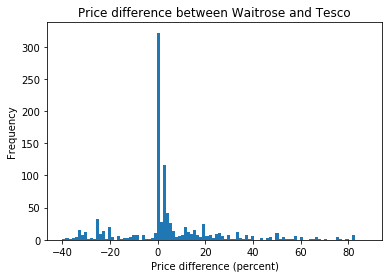

In [57]:
%matplotlib inline
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.hist(matched_prods_update['price_diff_pc'], bins=100, range=[-40.000000, 87.755102])
plt.xlabel('Price difference (percent)')
plt.ylabel('Frequency')
ax.set_title('Price difference between Waitrose and Tesco')
plt.plot



In [63]:
matched_prods_update.describe()

,wt_price,tesco_price,price_diff,price_diff_pc
count,1023.000000,1023.000000,1023.000000,1023.000000
mean,3.586676,3.521789,0.064888,5.720658
std,4.449462,4.562895,0.964769,25.213396
min,0.320000,0.320000,-14.000000,-50.000000
25%,1.500000,1.500000,0.000000,0.000000
50%,2.350000,2.400000,0.010000,0.502513
75%,4.000000,3.550000,0.200000,11.111111
max,40.150000,39.000000,9.750000,300.000000


The price of most products are about the same in two supermarkets.
The median price difference (Waitrose over Tesco) is 0.5 percent.
Median is used to avoid statistics being skewed by outliers eg. items heavily discounted for clearing stock.

pet 
 count    11.000000
mean     11.449678
std      19.356273
min     -28.000000
1%      -25.200000
25%       2.929293
50%      11.524164
75%      21.179775
99%      39.784461
max      40.000000
Name: price_diff_pc, dtype: float64
fresh_and_chilled 
 count    104.000000
mean       3.238209
std       18.203023
min      -37.500000
1%       -37.366935
25%        0.000000
50%        0.000000
75%        5.733083
99%       60.000000
max       60.000000
Name: price_diff_pc, dtype: float64
bakery 
 count    13.000000
mean     -8.527285
std       8.345572
min     -27.777778
1%      -26.844444
25%     -10.000000
50%     -10.000000
75%       0.000000
99%       0.000000
max       0.000000
Name: price_diff_pc, dtype: float64
frozen 
 count    47.000000
mean      0.043259
std      14.378105
min     -33.333333
1%      -33.230769
25%       0.000000
50%       0.000000
75%       3.095238
99%      37.222222
max      50.000000
Name: price_diff_pc, dtype: float64
food_cupboard 
 count    399.000000
mean  

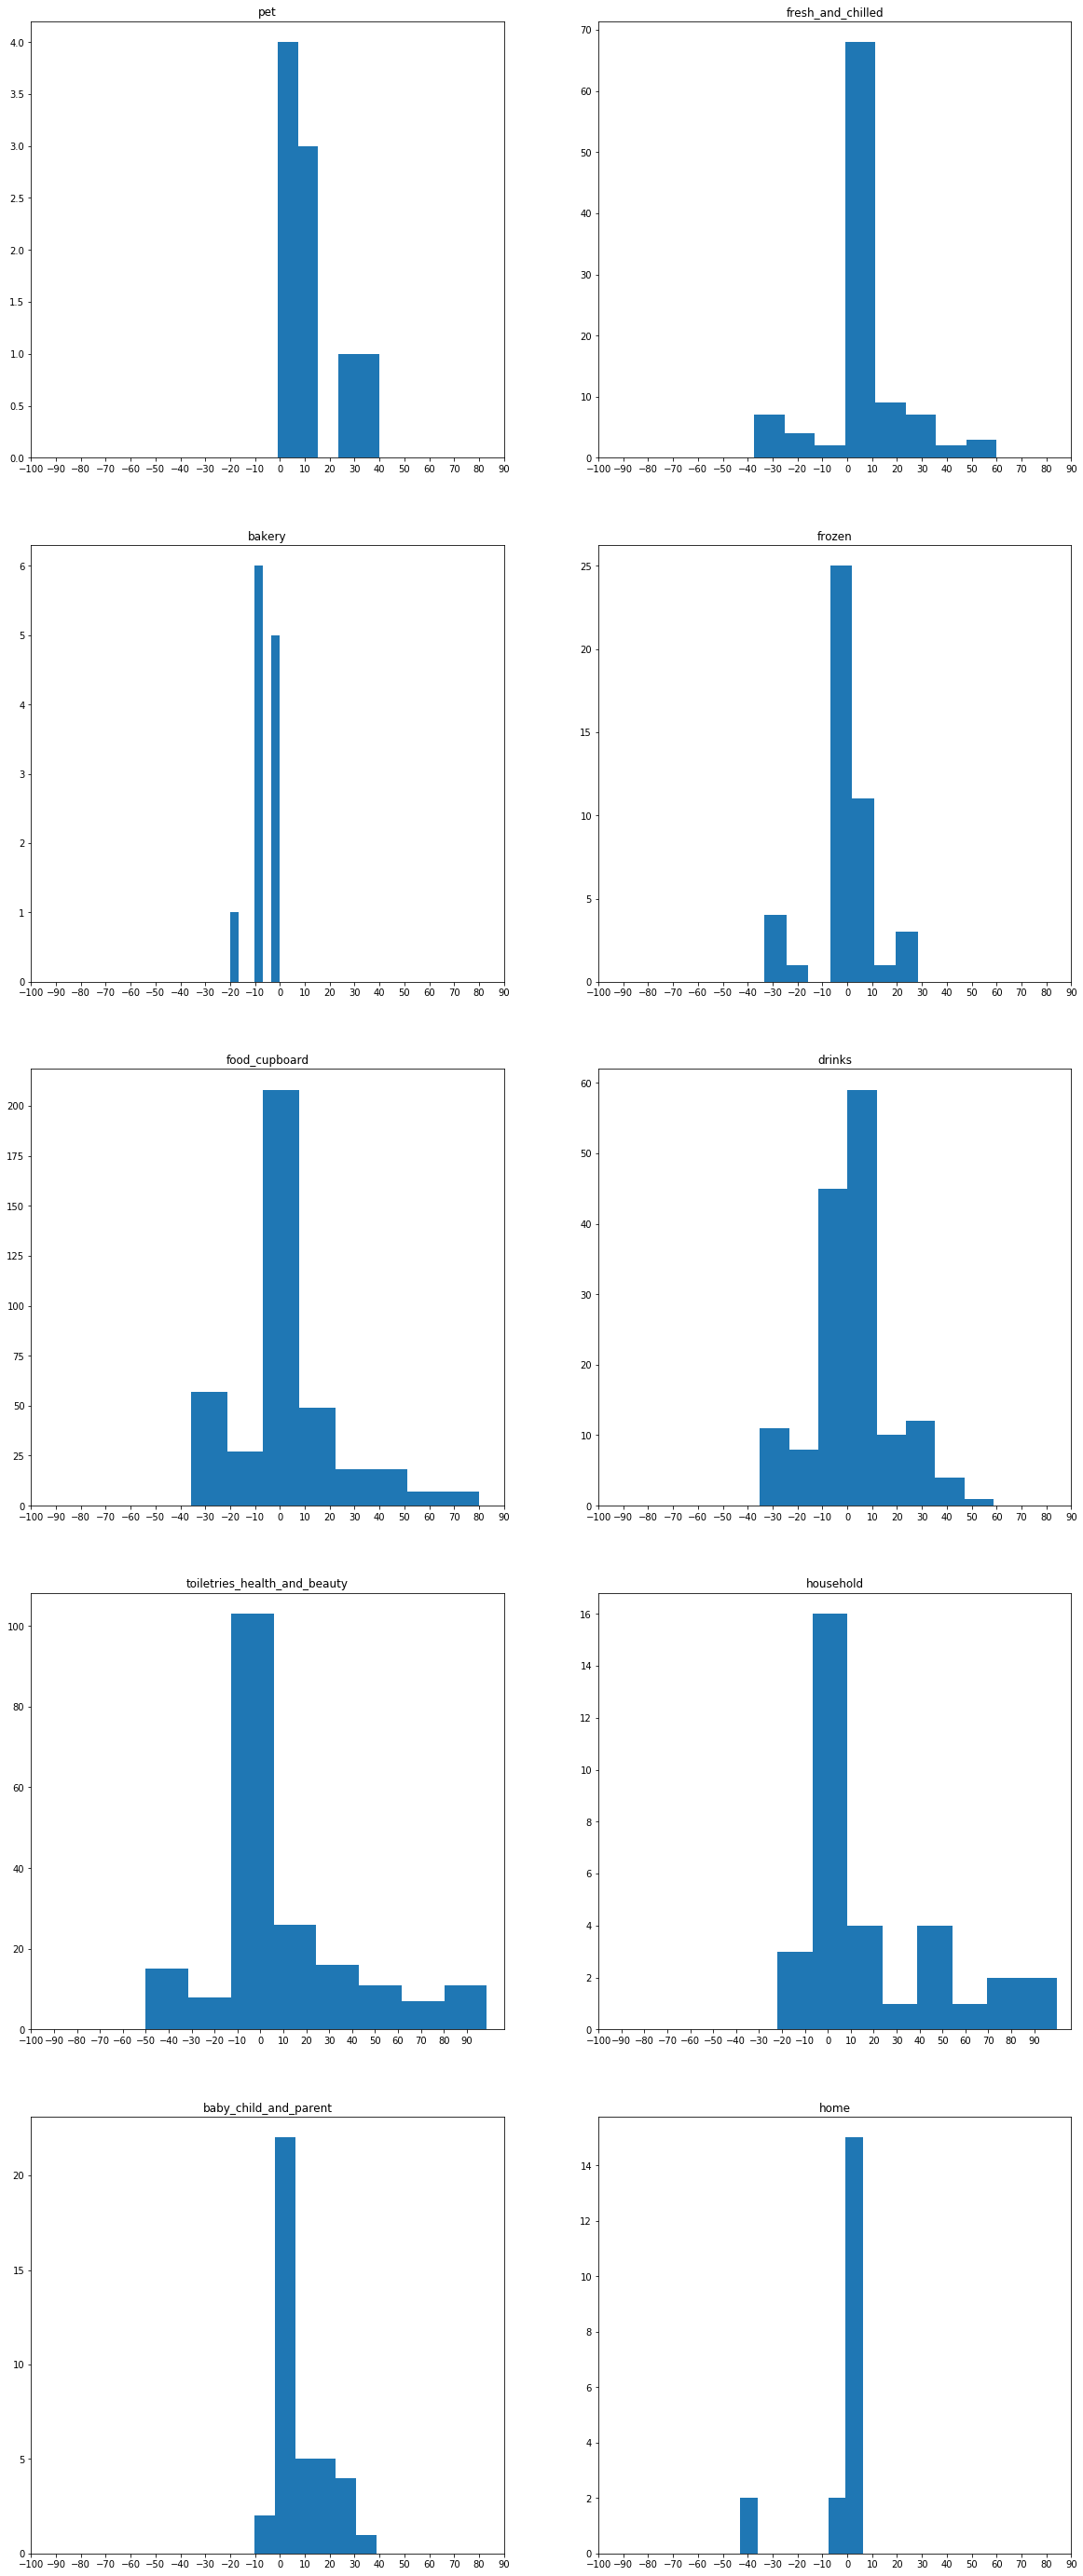

In [579]:
fig = plt.figure(figsize=(20,50))
cats = matched_prods_update['category'].unique()
fig_count = 1
for c in cats:
    selected_df = matched_prods_update.loc[matched_prods_update['category'] == c, 'price_diff_pc'].copy()
    pctl = selected_df.describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
    print(c, '\n', pctl)
    globals()['ax'+str(fig_count)] = fig.add_subplot(5, 2, fig_count)
    globals()['ax'+str(fig_count)].hist(selected_df, bins=8, range=[pctl['1%'], pctl['99%']])
    plt.xticks(np.arange(-100, 100, 10))
    globals()['ax'+str(fig_count)].set_title(c)
    fig_count += 1
plt.show()

pet: median price difference is 11.52%, which is significantly higher than other categories, but the number of products for comparison are limited (11).

fresh_and_chilled, frozen, food_cupboard: median price difference is 0%. In the histogram, more than half of the products are more expensive in Waitrose. In the histogram, there is a second peak at c.-30%. To investigate the products.

bakery: unlike other categories, products in Tesco are more expensive. To investigate the products.

drinks: median price difference is 2.03%. However, there are considerable number of products which are sold at slightly lower price in Waitrose. To investigate the products.

toiletries_health_and_beauty: median price difference is 3.08%. In the histogram, there is a second peak at c.-40%. To investigate the products.

household: median price difference is 1.43%. Most products are more expensive in Waitrose.

baby_child_and_parent: median price difference is 3.33%. Most products are more expensive in Waitrose.

home: median price difference is 0%. Most products are around the same price in two supermarkets.

In [103]:
cols=['wt_name','wt_price','tesco_price','price_diff','price_diff_pc','wt_offer','tesco_prod_promo','tesco_prod_msg']

In [98]:
for c in ['fresh_and_chilled','frozen','food_cupboard']:
    print(c)
    print('Products with offer in Waitrose\nprice_diff_pc median')
    w_offer = matched_prods_update[(matched_prods_update['category']==c)&(matched_prods_update['price_diff'] < 0)&(matched_prods_update['wt_offer']!='[]')]
    print(w_offer['price_diff_pc'].median())
    print(w_offer[cols])
    print('Products without offer in Waitrose\nprice_diff_pc median')
    wout_offer = matched_prods_update[(matched_prods_update['category']==c)&(matched_prods_update['price_diff'] < 0)&(matched_prods_update['wt_offer']=='[]')]
    print(wout_offer['price_diff_pc'].median())
    print(wout_offer[cols])

fresh_and_chilled
Products with offer in Waitrose
price_diff_pc median
-31.562500000000004
                                 wt_name  price_diff  price_diff_pc  \
125                 Benecol Light Spread       -0.50     -14.285714   
137                 Innocent Juice Apple       -1.01     -31.562500   
148      Tropicana Pink Grapefruit Juice       -0.82     -33.064516   
189              Innocent Juice Tropical       -1.01     -31.562500   
213    Ginsters Chicken & Mushroom Slice       -0.30     -23.076923   
227        Ginsters Peppered Steak Slice       -0.30     -23.076923   
228         Innocent Juice Apple & Mango       -1.01     -31.562500   
241       Tropicana Orange & Mango Juice       -0.82     -33.064516   
257         Jimmy's Iced Coffee Original       -0.60     -37.500000   
299            Jimmy's Iced Coffee Mocha       -0.60     -37.500000   
307    Jolly Hog 6 British Pork Sausages       -0.90     -30.000000   
1430        Innocent Juice Smooth Orange       -1.01     

By looking the median of price_diff_pc column of products with and without Waitrose offers, we can confirm the lower prices in Waitrose are due to discounts.

In [99]:
matched_prods_update[(matched_prods_update['category']=='bakery')&(matched_prods_update['price_diff']<0)][cols]

,wt_name,price_diff,price_diff_pc,wt_offer,tesco_prod_promo,tesco_prod_msg
319,Hovis Best of Both Medium,-0.11,-10.000000,[],[],[]
327,Hovis Wholemeal Medium,-0.11,-10.000000,[],[],[Aldi Price Match]
328,Hovis Soft White Medium,-0.11,-10.000000,[],[],[]
329,Soreen Sliced Malt Loaf,-0.04,-3.076923,[],[],[]
330,Hovis wholemeal thick,-0.11,-10.000000,[],[],[]
332,Hovis soft white thick,-0.11,-10.000000,[],[],[Aldi Price Match]
333,Hovis best of both thick,-0.11,-10.000000,[],[],[]
1799,Genius Triple Seeded Farmhouse Loaf,-0.50,-20.000000,"['save 50p.', ' Was £2.50']","[£2.00 Clubcard Price, Offer valid for deliver...",[]
1800,Mr Kipling Battenberg,-0.50,-27.777778,"['Save 1/3.', ' Was £1.95']",[],[]


For bakery products of which Waitrose prices are lower, many are not due to discount in Waitrose. It is interesting to note that two of them are being price matched to Aldi by Tesco.

In [114]:
matched_prods_update[(matched_prods_update['category']=='drinks')&(matched_prods_update['price_diff']<0)][cols+['tea_coffee_and_soft_drinks_flag','beer_wine_and_spirits_flag']]

,wt_name,wt_price,tesco_price,price_diff,price_diff_pc,wt_offer,tesco_prod_promo,tesco_prod_msg,tea_coffee_and_soft_drinks_flag,beer_wine_and_spirits_flag
798,Belvoir Ginger Cordial,2.50,3.29,-0.79,-24.012158,"['save 80p.', ' Was £3.30']","[£2.50 Clubcard Price, Offer valid for deliver...",[],True,False
807,Tick Tock Rooibos Tea 80 Tea Bags,3.00,3.70,-0.70,-18.918919,"['save 80p.', ' Was £3.80']",[],[],True,False
809,Belvoir Elderflower Cordial,2.50,3.29,-0.79,-24.012158,"['save 80p.', ' Was £3.30']","[£2.50 Clubcard Price, Offer valid for deliver...",[],True,False
817,Schweppes 1783 Crisp Tonic Water,3.10,3.15,-0.05,-1.587302,[],[],[],True,False
827,Robinsons Barley Water Lemon,1.50,1.99,-0.49,-24.623116,"['save 50p.', ' Was £2.00']",[],[],True,False
838,Schweppes 1783 Light Tonic Water,3.10,3.15,-0.05,-1.587302,[],[],[],True,False
849,Robinsons Barley Water Orange,1.50,1.99,-0.49,-24.623116,"['save 50p.', ' Was £2.00']",[],[],True,False
852,Belvoir Ginger Beer,2.00,2.49,-0.49,-19.678715,"['save 70p.', ' Was £2.70']","[£2.00 Clubcard Price, Offer valid for deliver...",[],True,False
872,Starbucks House Blend Ground Coffee,3.00,3.50,-0.50,-14.285714,"['save 55p.', ' Was £3.55']","[£3.00 Clubcard Price, Offer valid for deliver...",[],True,False
873,Kenco Smooth,4.00,4.50,-0.50,-11.111111,"['save £2.50.', ' Was £6.50']","[£4.00 Clubcard Price, Offer valid for deliver...",[],True,False


Drinks products which are sold at lower price in Waitrose are mosly due to discount, but prices of some (eg. index 852, 872, 873) are the same or lower at the 'Clubcard' price if the items were bought with their membership card in Tesco .


In [115]:
matched_prods_update[(matched_prods_update['category']=='toiletries_health_and_beauty')&(matched_prods_update['price_diff']<0)][cols]

,wt_name,wt_price,tesco_price,price_diff,price_diff_pc,wt_offer,tesco_prod_promo,tesco_prod_msg
1043,Aveeno Daily Moisturising Lotion,5.15,7.50,-2.35,-31.333333,"['Save 1/3.', ' Was £7.75']","[£5.00 Clubcard Price, Offer valid for deliver...",[]
1058,Colgate Total Deep Clean,2.00,2.85,-0.85,-29.824561,"['Half Price.', ' Was £4.00']","[£1.90 Clubcard Price, Offer valid for deliver...",[]
1113,Tampax Compak Super,2.45,2.60,-0.15,-5.769231,['Add 2 for £4'],[Any 2 for £5 - Selected Tampax Pearl Compak A...,[]
1226,Baylis & Harding White Tea & Neroli,1.50,2.25,-0.75,-33.333333,"['Save 1/3.', ' Was £2.25']",[],[Please keep and reuse your handwash pump disp...
1228,Oral-B 3D White Luxe Perfection,2.50,5.00,-2.50,-50.000000,"['Half Price.', ' Was £5.00']",[],[]
1273,Aveeno Moisturising Creamy Oil,5.15,7.50,-2.35,-31.333333,"['Save 1/3.', ' Was £7.75']","[£5.00 Clubcard Price, Offer valid for deliver...",[]
1280,Aveeno Moisturising Cream,4.80,7.50,-2.70,-36.000000,"['Save 1/3.', ' Was £7.25']","[£5.00 Clubcard Price, Offer valid for deliver...",[]
1283,Hask Keratin Protein Conditioner,4.65,7.00,-2.35,-33.571429,"['Save 1/3.', ' Was £7.00']",[],[]
1285,Lynx Africa Body Spray,2.80,2.86,-0.06,-2.097902,"['Save 1/3.', ' Was £4.25']",[],[Great Prices Every Day]
1297,Lynx Black Body Spray,2.80,2.86,-0.06,-2.097902,"['Save 1/3.', ' Was £4.25']",[],[Great Prices Every Day]


Similar to drinks, toiletries products which are sold at lower price in Waitrose are mosly due to discount, 
but prices of some (eg. index 1043, 1303) are the same or lower at the 'Clubcard' price if the items are bought in Tesco with their membership card.


Many products sold at lower price at Waitrose because there are discounts, but some of them are in fact same price/slightly higher price compared to Tesco if we use Tesco Clubcard to purchase, so how is the comparison if we assume customers have Tesco Clubcard and only buy single item (ie. multiple item offers (Add 2 for £4) are not taken into account)?

In [230]:
print(matched_prods_update['tesco_prod_promo'].value_counts())

[]                                                                                                                                                                                                                                                                                            758
[£1.00 Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021, £1.00 Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021]                                                                                                                             18
[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]                 18
[£1.50 Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021, £1.50 Clubcard Price, Offer valid for delivery f

Offers being taken by customers:
- £x.xx Clubcard Price
- Save £x.xx Was £xx.xx Now £x.xx (Note: discounted price is already in column 'tesco_price', as checked in the cells below)
- Reduced to Clear Was £xx.xx Now £x.xx (Note: discounted price is already in column 'tesco_price', as checked in the cells below)

In [245]:
matched_prods_update[matched_prods_update['tesco_prod_promo'].apply(lambda x: ''.join(x).find(r'Was') != -1)]

,wt_link,tesco_link,category,tea_coffee_and_soft_drinks_flag,beer_wine_and_spirits_flag,tesco_category,waitrose_index,tesco_index,tesco_id,wt_name_in_summary,...,tesco_prod_promo,tesco_name,tesco_price,tesco_prod_desc,price_diff,price_diff_pc,tesco_clubcard_price,tesco_price_w_clubcard,price_diff_tsc,price_diff_pc_tsc
716,https://www.waitrose.com/ecom/products/lindt-master-chocolatier-collection/886364-298717-298718,https://www.tesco.com/groceries/en-GB/products/305053948,food_cupboard,False,False,food_cupboard,9467,25297,305053948,lindt master chocolatier collection,...,"[Reduced to Clear Was £13.00 Now £3.25, Offer valid for delivery from 15/02/2021 until 24/05/2021, Reduced to Clear Was £13.00 Now £3.25, Offer valid for delivery from 15/02/2021 until 24/05/2021]",Lindt Master Chocolatier Collection 320G,3.25,"[Product Description, 31 assorted fine milk, dark and white chocolates., The Lindt Difference, Passion for chocolate at Every Step, Finest Cocoa - Lindt & Sprüngli Cocoa Farming Program, Roasting & Grinding, Lindt Invention Conching, Best Ingredients, Finishing with Perfection, From Bean to Bar, Lindt Sustainability, www.lindt.com, A gourmet selection of 11 delicious chocolate recipes, crafted with passion by the Lindt Master Chocolatier, Almond & Orange Delight*, Dark Chocolate Mousse, Oran...",9.75,300.000000,NaN,3.25,9.75,300.000000
898,https://www.waitrose.com/ecom/products/the-ned-sauvignon-blanc/012015-5940-5941,https://www.tesco.com/groceries/en-GB/products/277017257,drinks,False,True,drinks,11217,10100,277017257,the ned sauvignon blanc,...,"[Save £2.50 Was £9.50 Now £7.00, Offer valid for delivery from 16/02/2021 until 08/03/2021, Save £2.50 Was £9.50 Now £7.00, Offer valid for delivery from 16/02/2021 until 08/03/2021]",The Ned Sauvignon Blanc 75Cl,7.00,"[The Ned Marlborough Sauvignon Blanc 2020, Vivid aromas of freshly cut herbs, currant leaf and gooseberry waft from this elegant wine. Bursts of lemon and lime with a hint of guava create a lively mid-palate, a striking balance between fruit concentration and freshness with great length of flavour., Marisco Vineyards, home of The Ned, lies in Marlborough's stunning Southern Valleys. Our vineyard soils are created from the ancient, glacial movements of the Waihopai River. The unique environme...",3.99,57.000000,NaN,7.00,3.99,57.000000
956,https://www.waitrose.com/ecom/products/casillero-del-diablo-cabernet-sauvignon/064282-32622-32623,https://www.tesco.com/groceries/en-GB/products/254192146,drinks,False,True,drinks,11839,1436,254192146,casillero del diablo cabernet sauvignon,...,"[Save £2.00 Was £8.00 Now £6.00, Offer valid for delivery from 16/02/2021 until 22/02/2021, Save £2.00 Was £8.00 Now £6.00, Offer valid for delivery from 16/02/2021 until 22/02/2021]",Casillero Del Diablo Cabernet Sauvignon 75Cl,6.00,"[Winemaker's Notes, A smooth, full-bodied Cabernet Sauvignon with cassis and black cherry flavours, complemented by hints of coffee and dark chocolate., ""More than 100 years ago, Don Melchor de Concha y Toro set aside some of his best wines. To keep strangers away, he spread the rumor that the Devil lived in his cellar. Hence the Name: Casillero del Diablo"", 10.1 UK Units per bottle, Drink Responsibly, UK Government recommends adults do not regularly exceed:, Men 3-4 units a day, Women 2-3 u...",2.00,33.333333,NaN,6.00,2.00,33.333333
985,https://www.waitrose.com/ecom/products/dark-horse-sauvignon-blanc/675401-726428-726429,https://www.tesco.com/groceries/en-GB/products/295163384,drinks,False,True,drinks,12415,10894,295163384,dark horse sauvignon blanc,...,"[Save £1.50 Was £8.50 Now £7.00, Offer valid for delivery from 16/02/2021 until 08/03/2021, Save £1.50 Was £8.50 Now £7.00, Offer valid for delivery from 16/02/2021 until 08/03/2021]",Dark Horse Sauvignon Blanc 75Cl,7.00,"[Product Description, Sauvignon Blanc, White Wine, California, Dark Horse Sauvignon Blanc is a vibrant Sauvignon Blanc with notes of fresh tropical fruit and a refreshingly crisp fin

In [249]:
clubcard_price = matched_prods_update['tesco_prod_promo'].apply(lambda x: ''.join(x)).apply(lambda y: re.search(r'(£?[\d\.]+p?) Clubcard Price', y))

In [250]:
print(clubcard_price[clubcard_price.notna()].apply(lambda x: x.group(1)))

14       £2.75
16       £1.50
19       £1.50
83       £1.00
87       £1.00
89       £1.00
98       £1.00
106      £1.00
108      £1.00
125      £3.00
127      £1.00
137      £2.00
146      £1.00
148      £1.75
156      £2.50
169      £2.50
179      £2.50
189      £2.00
197      £2.50
228      £2.00
238      £1.00
241      £1.75
339      £2.00
340      £2.00
342      £2.00
343      £1.50
365      £1.50
369      £1.50
376      £1.00
379      £1.00
381      £1.50
382      £1.00
384      £1.50
393      £2.00
396      £1.30
412      £1.50
415      £1.50
418      £1.00
419      £2.00
420      £1.50
421      £1.00
429      £2.00
430      £1.45
431      £2.00
432      £1.50
434      £1.45
437      £1.00
439      £1.00
443      £1.00
448      £1.50
450      £1.00
451      £2.50
453      £1.00
459      £1.50
463      £1.30
464      £1.45
480      £1.00
482      £1.50
484      £1.50
496      £1.00
498      £2.00
499      £1.39
502      £2.00
506      £2.00
515      £1.50
519      £1.00
521      £

In [284]:
matched_prods_update['tesco_disc_single'] = clubcard_price[clubcard_price.notna()].apply(lambda x: x.group(1))

In [285]:
pound_mask = matched_prods_update['tesco_disc_single'].str.contains('£')
pound_mask.fillna(False, inplace=True)
matched_prods_update.loc[pound_mask, 'tesco_disc_single'] = matched_prods_update.loc[pound_mask, 'tesco_disc_single'].str.strip('£')
price_in_p_mask.fillna(False, inplace=True)
price_in_p_mask = matched_prods_update['tesco_disc_single'].str[-1]=='p'
matched_prods_update.loc[price_in_p_mask, 'tesco_disc_single'] = matched_prods_update.loc[price_in_p_mask, 'tesco_disc_single'].apply(lambda x: str(float(x.strip('p'))/100))
matched_prods_update['tesco_disc_single'] = matched_prods_update['tesco_disc_single'].astype('float')

In [286]:
print(matched_prods_update[matched_prods_update['tesco_disc_single'].notna()][['tesco_prod_promo','tesco_disc_single']].tail())

                                                                                                                                                        tesco_prod_promo  \
1831  [£2.00 Clubcard Price, Offer valid for delivery from 15/02/2021 until 01/03/2021, £2.00 Clubcard Price, Offer valid for delivery from 15/02/2021 until 01/03/2021]   
1832  [£1.00 Clubcard Price, Offer valid for delivery from 08/02/2021 until 28/02/2021, £1.00 Clubcard Price, Offer valid for delivery from 08/02/2021 until 28/02/2021]   
1834      [80p Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021, 80p Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021]   
1838  [£2.65 Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021, £2.65 Clubcard Price, Offer valid for delivery from 03/02/2021 until 23/02/2021]   
1846  [£3.30 Clubcard Price, Offer valid for delivery from 10/02/2021 until 23/03/2021, £3.30 Clubcard Price, Offer valid for delivery from 

In [287]:
def lowest_ts_price(df):
    if pd.notna(df['tesco_disc_single']):
        return min(df['tesco_disc_single'], df['tesco_price'])
    return df['tesco_price']

In [288]:
matched_prods_update['tesco_disc_single'] = matched_prods_update.apply(lowest_ts_price, axis=1)

In [289]:
print(matched_prods_update['wt_offer'].value_counts())

[]                                                      718
['Add 2 for £3']                                         15
['Add 2 for £7']                                         12
['Add 2 for £4']                                         10
['Add 3 for £10']                                         9
['save 50p.', ' Was £2.50']                               8
['save 95p.', ' Was £2.95']                               7
['save 60p.', ' Was £2.60']                               7
['Add 2 for £3.50']                                       7
['Mix & Match Add 4 for 3 Cheapest Item Free']            5
['save 55p.', ' Was £2.05']                               5
['Half Price.', ' Was £5.00']                             5
['Save 1/3.', ' Was £3.30']                               4
['25% Off.', ' Was £2.10']                                4
['save 65p.', ' Was £1.65']                               4
['Add 2 for £2']                                          4
['Add 3 for £1.50']                     

Offers being taken by customers:
    - Save £x.xx/Save 1/3/Half Price Was £xx.xx (Note: discounted price is already in column 'wt_price', as checked in the cells below)
    - Reduced to Clear Was £xx.xx Now £x.xx (Note: discounted price is already in column 'wt_price', as checked in the cells below)

In [309]:
matched_prods_update[matched_prods_update['wt_offer'].apply(lambda x: 'Was' in x)][['wt_price','wt_offer']]

,wt_price,wt_offer
8,0.90,"['25% Off.', ' Was £1.25']"
124,1.50,"['save 40p.', ' Was £1.90']"
125,3.00,"['save 75p.', ' Was £3.75']"
137,2.19,"['Save 1/3.', ' Was £3.30']"
148,1.66,"['Save 1/3.', ' Was £2.55']"
189,2.19,"['Save 1/3.', ' Was £3.30']"
213,1.00,"['save 75p.', ' Was £1.75']"
227,1.00,"['save 75p.', ' Was £1.75']"
228,2.19,"['Save 1/3.', ' Was £3.30']"
241,1.66,"['Save 1/3.', ' Was £2.55']"


In [321]:
matched_prods_update['price_diff_single'] = matched_prods_update['wt_price'] - matched_prods_update['tesco_disc_single']

In [322]:
matched_prods_update['price_diff_pc_single'] = matched_prods_update['price_diff_single'] / matched_prods_update['tesco_disc_single'] * 100

In [324]:
# matched_prods_wtoffer = matched_prods_update[matched_prods_update['wt_offer'] != '[]'].copy()

pet 
 count    11.000000
mean     11.449678
std      19.356273
min     -28.000000
1%      -25.200000
25%       2.929293
50%      11.524164
75%      21.179775
99%      39.784461
max      40.000000
Name: price_diff_pc_single, dtype: float64
fresh_and_chilled 
 count    104.000000
mean      16.133236
std       26.310883
min      -37.500000
1%       -37.275000
25%        0.000000
50%        2.500000
75%       35.052448
99%       69.000000
max      100.000000
Name: price_diff_pc_single, dtype: float64
bakery 
 count    13.000000
mean     -6.988823
std       7.885139
min     -27.777778
1%      -25.644444
25%     -10.000000
50%     -10.000000
75%       0.000000
99%       0.000000
max       0.000000
Name: price_diff_pc_single, dtype: float64
frozen 
 count     47.000000
mean      11.244969
std       26.980346
min      -33.333333
1%       -33.230769
25%        0.000000
50%        0.436681
75%       13.238095
99%       93.100000
max      100.000000
Name: price_diff_pc_single, dtype: float64
food

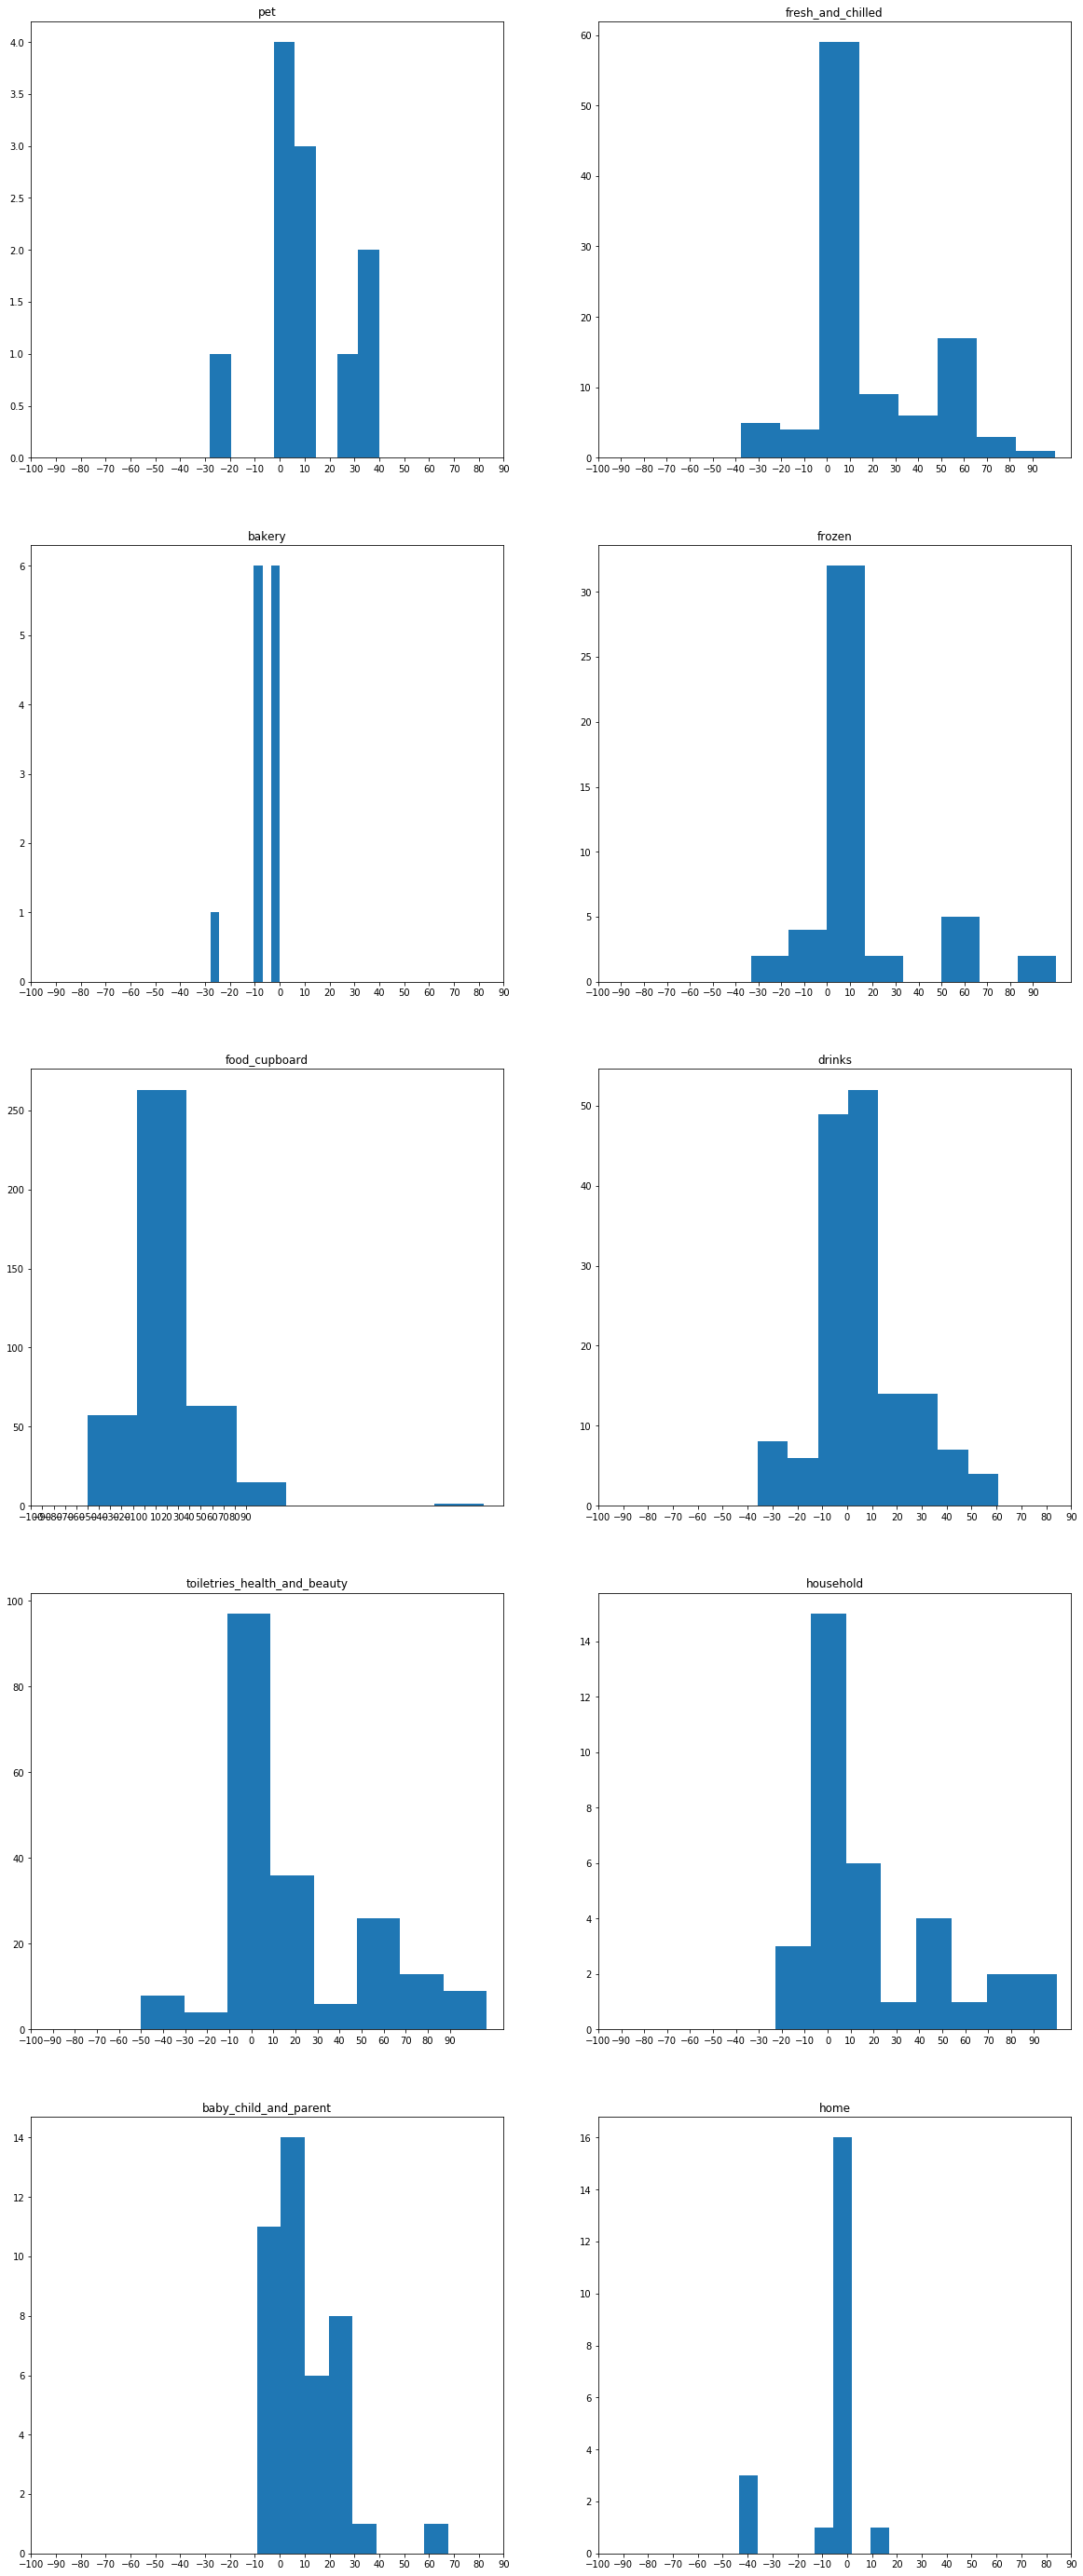

In [580]:
fig = plt.figure(figsize=(20,50))
cats = matched_prods_update['category'].unique()
fig_count = 1
for c in cats:
    selected_df = matched_prods_update[matched_prods_update['category'] == c].copy()
    pctl = selected_df['price_diff_pc_single'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
    print(c, '\n', pctl)
    globals()['ax'+str(fig_count)] = fig.add_subplot(5, 2, fig_count)
    globals()['ax'+str(fig_count)].hist(selected_df['price_diff_pc_single'], bins=8)
    plt.xticks(np.arange(-100, 100, 10))
    globals()['ax'+str(fig_count)].set_title(c)
    fig_count += 1
plt.show()

In [578]:
ax1

In [326]:
# matched_prods_wtoffer[matched_prods_wtoffer['category']=='frozen'][['wt_name', 'tesco_name', 'wt_price', 'tesco_price', 'tesco_prod_promo', 'wt_offer', 'price_diff_pc_tsc']]

Using Tesco Clubcard tesco has driven the median price_diff_pc to >= 0% across categories (except for bakery which is an outlier). 

Many of the Waitrose offers are for multi-items purchase. In addition to using Tesco Clubcard, would the prices in Waitrose or Tesco lower if customers are willing to buy more?

In [338]:
wt_offer_list = matched_prods_update['wt_offer'].unique()
[i for i in wt_offer_list if 'Was' not in i]

['[]',
 "['Add 2 for £8']",
 "['Add 3 for £6']",
 "['Add 2 for £7.50']",
 "['Add 2 for £4']",
 "['Add 2 for £3']",
 "['Add 2 for £5']",
 "['Add 2 for £3.50']",
 "['Add 3 for £1.50']",
 "['Add 3 for £3']",
 "['Add 5 for £3']",
 "['Add 2 for £2']",
 "['Add 3 for £1']",
 "['Add 4 for £4']",
 "['Add 3 for £5']",
 "['Mix & Match Add 4 for 3 Cheapest Item Free']",
 "['Add 2 for £7']",
 "['Add 3 for £10']",
 "['Add 2 for £9']",
 "['Add 3 for £2.50']",
 "['Add 3 for £4.50']",
 "['Add 2 get 2nd half price Cheaper Item Half Price']",
 "['Add 6 for £6']",
 "['Add 3 for £4']",
 "['Add 2 for £6']",
 "['Add 6 for £5.50']"]

Waitrose
Offers for multi-item purchase
    - Add x for £x
    - Any x for x ... 
    - Add x get xx half price
    
It is assumed that same product is bought in mix and match offers

In [375]:
matched_prods_update['wt_disc_multi'] = np.NaN
add_x_for_x_pound_mask = matched_prods_update[(matched_prods_update['wt_offer'].str.contains(r'Add \d+ for £\d+') == True)].index
axfxp_total_price = matched_prods_update.loc[add_x_for_x_pound_mask, 'wt_offer'].str.extract('£(.+)\'\]').astype('float')
axfxp_total_qty = matched_prods_update.loc[add_x_for_x_pound_mask, 'wt_offer'].str.extract(r'Add (\d+) for').astype('int')
axfxp_avg_price = axfxp_total_price / axfxp_total_qty
matched_prods_update.loc[add_x_for_x_pound_mask, 'wt_disc_multi'] = axfxp_avg_price.values

In [398]:
add_4_for_3_mask = matched_prods_update[matched_prods_update['wt_offer'] == "['Mix & Match Add 4 for 3 Cheapest Item Free']"].index
matched_prods_update.loc[add_4_for_3_mask,'wt_disc_multi'] = matched_prods_update.loc[add_4_for_3_mask, 'wt_price'] * 3 / 4
add_2_2nd_half_mask = matched_prods_update[matched_prods_update['wt_offer'] == "['Add 2 get 2nd half price Cheaper Item Half Price']"].index
matched_prods_update.loc[add_2_2nd_half_mask,'wt_disc_multi'] = matched_prods_update.loc[add_2_2nd_half_mask, 'wt_price'] * 1.5 / 2

In [399]:
matched_prods_update[matched_prods_update['wt_disc_multi'].notna()][['wt_price', 'wt_offer', 'wt_disc_multi']]

,wt_price,wt_offer,wt_disc_multi
1,5.50,['Add 2 for £8'],4.000000
2,2.30,['Add 3 for £6'],2.000000
6,5.20,['Add 2 for £7.50'],3.750000
145,2.15,['Add 2 for £4'],2.000000
265,2.05,['Add 2 for £3'],1.500000
289,2.05,['Add 2 for £3'],1.500000
343,3.00,['Add 2 for £4'],2.000000
348,3.65,['Add 2 for £5'],2.500000
381,2.00,['Add 2 for £3'],1.500000
384,2.00,['Add 2 for £3'],1.500000


In [403]:
matched_prods_update['wt_disc_multi'].fillna(matched_prods_update['wt_price'], inplace=True)

In [530]:
# the word 'Was' was used in tesco_prod_promo column to show discount available for purchasing single item
ts_not_single_disc_mask = matched_prods_update[matched_prods_update['tesco_prod_promo'].apply(lambda x: ('Was' not in ' '.join(x)) and ('Clubcard Price' not in ' '.join(x)) and len(x) > 0)].index
matched_prods_update.loc[ts_not_single_disc_mask, 'tesco_prod_promo'].value_counts()

[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]                18
[Any 4 for £6 - Selected Beers 250ml - 500ml, Offer valid for delivery from 16/02/2021 until 08/03/2021, Any 4 for £6 - Selected Beers 250ml - 500ml, Offer valid for delivery from 16/02/2021 until 08/03/2021]                                                                              11
[Any 3 for £10 - Selected Head & Shoulders Shampoo Or Conditioner 275ml-500ml, Offer valid for delivery from 10/02/2021 until 23/03/2021, Any 3 for £10 - Selected Head & Shoulders Shampoo Or Conditioner 275ml-500ml, Offer valid for delivery from 10/02/2021 until 23/03/2021]             9
[Any 4 for 3 - Cheapest Product Free - Selected Premix Cans 187ml - 500ml, Offer valid for delivery from 11/01/2021 until 31/05/2021,

Tesco
Offers for multi-item purchase
    - Any x for £x
    - Any x for x
    - Buy x save £x

'£3 Meal Deal...' excluded because it is difficult to quantify the saving with the variety of choices in meal deal
Tesco BookClub: it is not obvious from the description what the savings would be

In [524]:
matched_prods_update['tesco_disc_multi'] = np.NaN
# matched_prods_update[
ts_promo_str = matched_prods_update['tesco_prod_promo'].apply(lambda x: ' '.join(x))
axfxp_index = matched_prods_update[ts_promo_str.str.contains('Any \d+ for £\d+')].index
axfxp_total_price = ts_promo_str.loc[axfxp_index].str.extract(r'for £([\d.]+) ').astype('float')
axfxp_total_qty = ts_promo_str.loc[axfxp_index].str.extract(r'Any (\d+) for').astype('int')
axfxp_avg_price = axfxp_total_price / axfxp_total_qty
matched_prods_update.loc[axfxp_index, 'tesco_disc_multi'] = axfxp_avg_price.values
axfx_index = matched_prods_update[ts_promo_str.str.contains('Any \d+ for \d+')].index
axfx_get_qty = ts_promo_str.loc[axfx_index].str.extract(r'Any (\d+) for').astype('int')
axfx_paid_qty = ts_promo_str.loc[axfx_index].str.extract(r'for (\d+)').astype('int')
axfx_avg_price = matched_prods_update.loc[axfx_index, 'tesco_price']  * axfx_paid_qty[0] / axfx_get_qty[0]
matched_prods_update.loc[axfx_index, 'tesco_disc_multi'] = axfx_avg_price.values
matched_prods_update.loc[axfx_index, ['tesco_prod_promo', 'tesco_price', 'tesco_disc_multi']]
bxsx_index = matched_prods_update.loc[ts_promo_str.str.contains(r'Buy \d+ Save £\d+')].index
bxsx_total_qty = ts_promo_str[bxsx_index].str.extract(r'Buy (\d+) Save £\d+').astype('int')
bxsx_save = ts_promo_str[bxsx_index].str.extract(r'Buy \d+ Save £(\d+)').astype('float')
bxsx_avg_price = (matched_prods_update.loc[bxsx_index, 'tesco_price'] * bxsx_total_qty[0] - bxsx_save[0]) / bxsx_total_qty[0]
matched_prods_update.loc[bxsx_index, 'tesco_disc_multi'] = bxsx_avg_price.values

In [531]:
matched_prods_update.loc[ts_not_single_disc_mask, ['tesco_price','tesco_prod_promo','tesco_disc_multi']]

,tesco_price,tesco_prod_promo,tesco_disc_multi
257,1.60,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN
265,2.00,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN
281,1.60,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN
289,2.00,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN
299,1.60,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN
311,0.59,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN
422,0.65,"[Any 4 for £2 - Selected Heinz Hoops Or Pasta In Tomato Sauce 400g, Offer valid for delivery from 22/10/2020 until 22/02/2021, Any 4 for £2 - Selected Heinz Hoops Or Pasta In Tomato Sauce 400g, Offer valid for delivery from 22/10/2020 until 22/02/2021]",0.500000
426,0.65,"[Any 4 for £2 - Branston Baked Beans In Tomato Sauce Or Reduced Sugar & Salt 410g, Offer valid for delivery from 03/02/2021 until 23/02/2021, Any 4 for £2 - Branston Baked Beans In Tomato Sauce Or Reduced Sugar & Salt 410g, Offer valid for delivery from 03/02/2021 until 23/02/2021]",0.500000
465,1.10,"[Any 3 for £3 - Selected Heinz Beans Or Pasta Meals 400g - 415g, Offer valid for delivery from 22/10/2020 until 22/02/2021, Any 3 for £3 - Selected Heinz Beans Or Pasta Meals 400g - 415g, Offer valid for delivery from 22/10/2020 until 22/02/2021]",1.000000
514,0.85,"[£3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021, £3 Meal Deal - Selected Drink, Snack, Wrap, Sandwich, Roll, Pasty Or Salad, Offer valid for delivery from 31/01/2021 until 23/05/2021]",NaN


In [534]:
matched_prods_update['tesco_disc_multi'].fillna(matched_prods_update['tesco_disc_single'], inplace=True)

In [541]:
matched_prods_update['price_diff_multi'] = matched_prods_update['wt_disc_multi'] - matched_prods_update['tesco_disc_multi']
matched_prods_update['price_diff_pc_multi'] = matched_prods_update['price_diff_multi'] / matched_prods_update['tesco_disc_multi'] * 100

In [776]:
cats = matched_prods_update['category'].unique()
for c in cats:
    selected_df = matched_prods_update[matched_prods_update['category'] == c].copy()
    pctl = selected_df['price_diff_pc_multi'].describe()
    print(c, pctl)

pet count    11.000000
mean      4.183559
std      20.716038
min     -28.000000
25%      -5.555556
50%       3.636364
75%      12.359551
max      40.000000
Name: price_diff_pc_multi, dtype: float64
fresh_and_chilled count    104.000000
mean      15.533302
std       27.931266
min      -37.500000
25%        0.000000
50%        2.403846
75%       36.363636
max      100.000000
Name: price_diff_pc_multi, dtype: float64
bakery count    13.000000
mean     -6.988823
std       7.885139
min     -27.777778
25%     -10.000000
50%     -10.000000
75%       0.000000
max       0.000000
Name: price_diff_pc_multi, dtype: float64
frozen count    47.000000
mean      7.607684
std      23.570407
min     -33.333333
25%       0.000000
50%       0.257069
75%       8.601732
max      85.000000
Name: price_diff_pc_multi, dtype: float64
food_cupboard count    399.000000
mean      11.804979
std       32.249074
min      -49.748744
25%        0.000000
50%        0.000000
75%       22.447552
max      300.000000
Name: 

In [774]:
def plot_hist(selected_df, col, fig_count_ori, plot_color, plot_label, plot_title=''):
    from matplotlib.ticker import MaxNLocator
    globals()['ax'+str(fig_count_ori)] = fig.add_subplot(10, 3, fig_count_ori)
    globals()['ax'+str(fig_count_ori)].hist(selected_df[col], bins=10, range=[pctl['1%'], pctl['99%']], color=plot_color, label=plot_label)
    globals()['ax'+str(fig_count_ori)].yaxis.set_major_locator(MaxNLocator(integer=True))
    globals()['ax'+str(fig_count_ori)].set_title(plot_title, fontsize=20, loc='left')
    plt.xticks(np.arange(-100, 100, 10))
    plt.xlabel('Waitrose price - Tesco price (in %)', fontsize=15)
    plt.ylabel('Count of products', fontsize=15)
#     print(plt.yticks()[0])
    if col == 'price_diff_pc':
        globals()['yticks_range'] = plt.yticks()[0]
    else: 
        plt.yticks(globals()['yticks_range'][:-1])
    plt.legend(loc='upper right', prop={'size': 10})
    fig_count_new = fig_count_ori + 1
    return fig_count_new

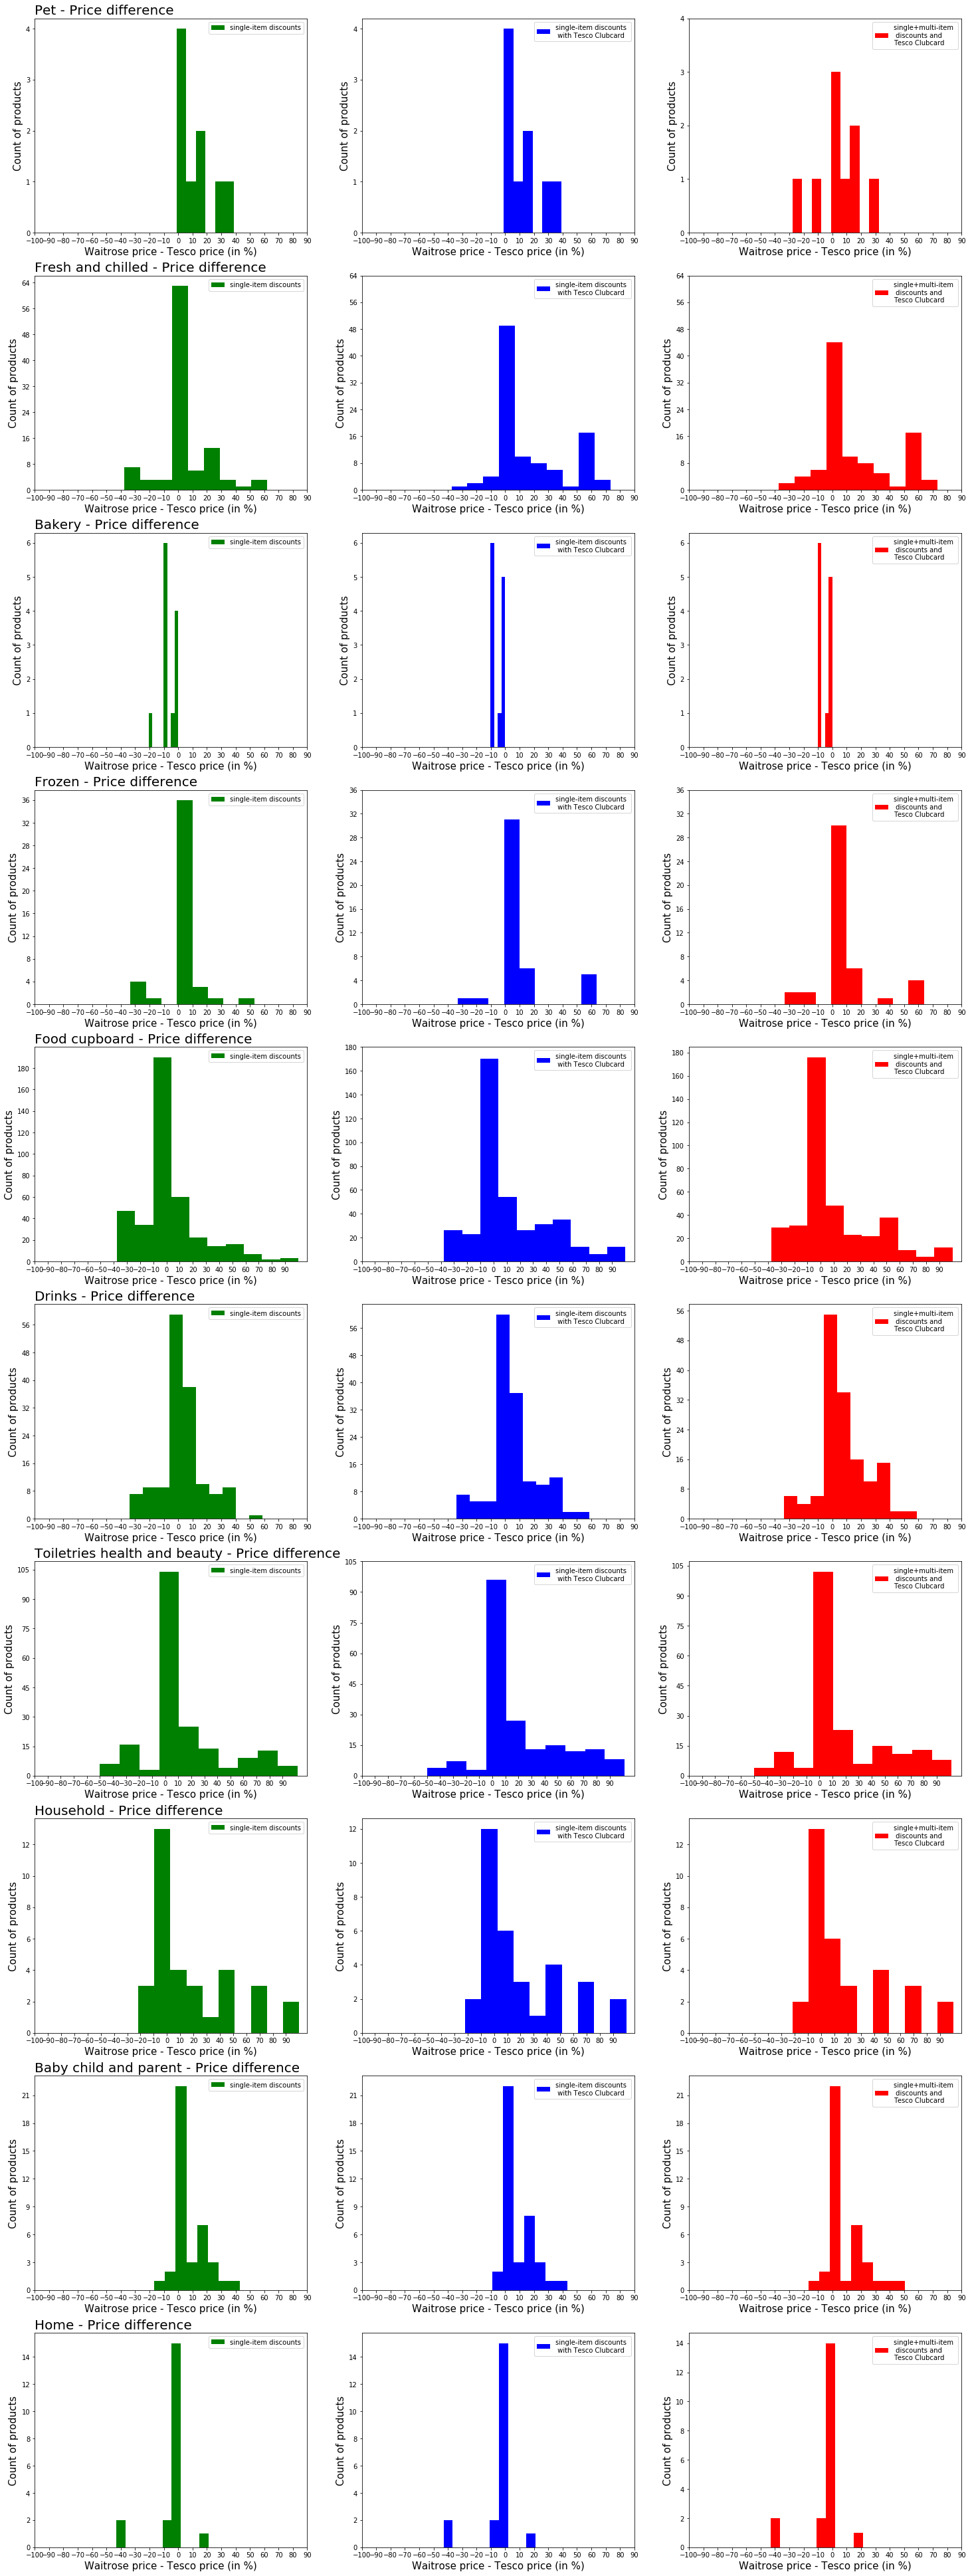

In [775]:
fig = plt.figure(figsize=(25,70))
fig_count = 1
for c in cats:
    selected_df = matched_prods_update[matched_prods_update['category'] == c].copy()
    pctl = selected_df['price_diff_pc_multi'].describe(percentiles=[0.01, 0.25, 0.5, 0.75, 0.99])
    display_c = c[0].upper()+c[1:].replace('_', ' ')
    fig_count = plot_hist(selected_df, 'price_diff_pc', fig_count, 'g', 'single-item discounts', f'{display_c} - Price difference')
    fig_count = plot_hist(selected_df, 'price_diff_pc_single', fig_count, 'b', 'single-item discounts \n with Tesco Clubcard')
    fig_count = plot_hist(selected_df, 'price_diff_pc_multi', fig_count, 'r', 'single+multi-item \n discounts and \nTesco Clubcard')
        
plt.show()

Conclusion

Across all categories (except bakery which is regarded as outlier category as explained above), assuming customers use Tesco Clubcard and are willing to take up multi-item discounts:
- For most products, price difference falls within bin around 0%. 
- The price difference for products with higher price in Waitrose spread in a wider range compared to products that are cheaper in Waitrose.
- Median price difference is equal to or above zero.
    
Taking up multi-item discounts does not significantly change the result. 

In [145]:
import dill

In [452]:
dill.dump_session('notebook_env.db')

In [1]:
import dill
dill.load_session('notebook_env.db')